In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py


In [2]:
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [3]:
fsamp=5000
res=50000
freqs=np.linspace(0,int(fsamp/2),(int(res/2))+1)    # change


In [4]:
def load_dir_reduced(dirname,file_prefix,max_files):
    '''
    Load time information from the h5 files in a loop into a list. Step size is fixed to 100. 
    '''   
    ## Load all filenames in directory
    var_list1 = []
    var_list2 = []
    var_list3 = []
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.h5')]
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    print(len(files))
    step_size = 50
    for j in np.arange(0,max_files,step_size):
        for filename in files[j:j+step_size]:
            BDFs = BDF.BeadDataFile(dirname+filename)
            var_list1.append(BDFs.x2)
            var_list2.append(BDFs.cant_pos[1])
            var_list3.append(BDFs.y2)
    return var_list1,var_list2,var_list3

In [5]:
def data_to_amp_and_phase_single_axis(data,fsamp,res):
    data_det=signal.detrend(data)
    freqs=np.linspace(0,int(fsamp/2),(int(res/2))+1)    # change
    FFT=np.fft.rfft(data_det)
    norm = np.sqrt(2 / (res* fsamp))
    PSD = norm**2 * (FFT * FFT.conj()).real
    Phase =np.angle(FFT)
    return PSD,Phase

## verification of the methods comparability to previously used mlab.psd

# fsamp=5000
# res=50000
# data=f[0].x2
# a = data_to_amp_and_phase_single_axis(data,fsamp,res)
# b = matplotlib.mlab.psd(signal.detrend(data), Fs = fsamp, NFFT = res, window = mlab.window_none)
# plt.loglog(a[0],a[1])
# plt.loglog(b[1],b[0],alpha=0.5)

In [6]:
def loop_extract_PSD_and_phase(inList,fsamp,res,calibrationFactor=1):
    ampList = []
    phaseList=[]
    for i in range(len(inList)):
        data=inList[i]/calibrationFactor
        temp_ = data_to_amp_and_phase_single_axis(data,fsamp,res)
        ampList.append(temp_[0])
        phaseList.append(temp_[1])
    return ampList,phaseList

In [7]:
def extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True,calibrationFactorX=1,calibrationFactorY=1,fsamp=5000,res=50000):
    start=time.time()

    df= pd.DataFrame()
    fsamp=fsamp
    res=res
    freqs=np.linspace(0,int(fsamp/2),(int(res/2))+1)
    x2L,cPL,y2L = load_dir_reduced(folderName,file_prefix=filePrefix,max_files=maxFiles)
    xAmpList,xPhaseList = loop_extract_PSD_and_phase(x2L,fsamp,res,calibrationFactorX)
    yAmpList,yPhaseList = loop_extract_PSD_and_phase(y2L,fsamp,res,calibrationFactorY)
    
    df["cantPosY"] = cPL
    
    df["xAmp"] = x2L
    df["xPhase"] = xPhaseList
    df["xPSD"] = xAmpList
    #df["xASD"]=df["xPSD"].apply(lambda element: np.sqrt(element))
    
    df["yAmp"] = y2L
    df["yPhase"] = yPhaseList
    df["yPSD"] = yAmpList
    #df["yASD"]=df["yPSD"].apply(lambda element: np.sqrt(element))
    
    
    df["checkStd"]=df["xAmp"].apply(lambda element: np.std(element))
    

    if(filterStd==True):
        df=df[df["checkStd"]<20*df["checkStd"].median()]
        df = df.reset_index()
    print("The process took %.2f" %(time.time()-start))
    print(df.info(memory_usage='deep'))

    return freqs,df

In [8]:
# transform the drive into phases
def add_driveFFT_for_harmonics(df,frequency):
    df["driveFFT"] = df["cantPosY"].apply(lambda element: data_to_amp_and_phase_single_axis(element,fsamp,res)[1][frequency*int(res/fsamp)::frequency*int(res/fsamp)])
    return df

In [9]:
def plot_compare_amplitudes_tot(frequency,df_1,df_2,method="ASD",axis="y",fsamp=5000,res=50000,
                                       label1="None",label2="None",
                                       lowxlim=10,upxlim=150,lowylim=1e-11,upylim=1,offset=2):
    if method == "Alternate":
        data1=data_to_amp_and_phase_single_axis(df_1["%sAmp" %axis].sum(),fsamp,res)[0]
        data2=data_to_amp_and_phase_single_axis(df_2["%sAmp" %axis].sum(),fsamp,res)[0]            
        xlabel="frequency [Hz]"
        ylabel="%s sumPSD [a.u.]" %axis
    if method == "ASD":
        data1=np.sqrt(df_1["%sPSD" %axis].sum()/len(df_1))
        data2=np.sqrt(df_2["%sPSD" %axis].sum()/len(df_2))
        xlabel="frequency [Hz]"
        ylabel="%s normalized ASD [m/$\sqrt{Hz}$]" %axis
        
        
    plt.plot(freqs,data1,color="black",alpha=1,lw=3,label=label1)
    plt.plot(freqs,data2,color="red",alpha=0.7,lw=3,label=label2)
    plt.yscale("log")
    plt.xlim(lowxlim,upxlim)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.legend()
    plt.show()
    
    fundamental=frequency
    plt.plot(freqs[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],data1[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],color="black",alpha=1,lw=3,marker="*",ms=15,label=label1)
    plt.plot(freqs[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],data2[fundamental*int(res/fsamp)::fundamental*int(res/fsamp)],color="red",alpha=0.7,lw=3,marker="*",ms=15,label=label2)
    
    plt.plot(freqs[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],data1[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],color="blue",alpha=0.7,lw=3,ls="dashed",marker="*",ms=15,label=label1+" off-axis check at %d" %(fundamental+offset))
    plt.plot(freqs[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],data2[(fundamental+offset)*int(res/fsamp)::(fundamental+offset)*int(res/fsamp)],color="blue",alpha=0.7,lw=3,ls="dotted",marker="*",ms=15,label=label2+" off-axis check at %d"%(fundamental+offset))

    plt.yscale("log")
    plt.xlim(lowxlim,upxlim)
    plt.ylim(lowylim,upylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [10]:
def plot_compare_phases(frequency,df_1,df_2,axis="y",label1="None",label2="None",noHarmonics=10,fsamp=5000,res=50000,compareDrive=False):
    for j in range(noHarmonics):
        PhaseListY0 = []
        PhaseListY1 = []
        for i in range(len(df_1)):
            PhaseListY0.append(df_1["%sPhase" %axis][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
        for i in range(len(df_2)):
            PhaseListY1.append(df_2["%sPhase" %axis][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
        plt.title("%sth Harmonic" %(j+1))    
        plt.xlabel("%s Phase [$\pi$]" %axis)
        plt.ylabel("normalized Counts")
        plt.hist(PhaseListY0,bins=100,range=(-1,1),label=label1,density=True)
        plt.hist(PhaseListY1,bins=100,range=(-1,1),label=label2,alpha=0.5,density=True)
        if(compareDrive==True):
            plt.axvline(df_1["driveFFT"][0][j]/np.pi,ls="dashed",color="red",lw=7)
        plt.legend()
        plt.show()

In [11]:
def plot_compare_phases_all(frequency,dfs,axis="y",labels=[],noHarmonics=10,fsamp=5000,res=50000,compareDrive=False):
    for j in range(noHarmonics):
        k=0
        for df in dfs:
            k+=1
            PhaseListY0 = []
            for i in range(len(df)):
                PhaseListY0.append(df["%sPhase" %axis][i][int(res/fsamp)*frequency*(j+1)]/np.pi)
            plt.hist(PhaseListY0,bins=100,range=(-1,1),label=labels[k-1],density=True,alpha=0.5)
        plt.title("%sth Harmonic" %(j+1))    
        plt.xlabel("%s Phase [$\pi$]" %axis)
        plt.ylabel("normalized Counts") 
        plt.legend()
        plt.show()
        

In [12]:
# #load the data
# df_NoShaking0 = pd.read_pickle("Results/NoShaking_0_20220613.npy")
# df_Shaking13 = pd.read_pickle("Results/Shaking_1_20220613.npy")
# df_Shaking3 = pd.read_pickle("Results/Shaking_2_20220613.npy")
# plot_compare_phases(13,df_NoShaking0,df_Shaking13)
# plot_compare_amplitudes_tot(13,df_NoShaking0,df_Shaking13,method="Alternate")

In [13]:
# settings to the ASM003 from Gautam - settings are the same as for me
fExc = 13.1415
excAmp = 50e-3/2 * 15 #mV, the factor of 15 gets us to the actual voltage applied to the ASM003 piezos.
# Calibration numbers from elog 337
xCal, yCal = 7.83e-6, 5.54e-6 # urad/V
excAmpX, excAmpY = xCal*excAmp*1.27000000e-02, yCal*excAmp*1.27000000e-02 # m, last factor is to convert to motion at trap focus

In [15]:
dates=[20220526,20220527,20220607,20220613,20220620]#,20220628]
for date in dates:
    folderName="/data/new_trap/%d/ASMcal/Xexc/" %date
    filePrefix="ASMcal"
    files = load_dir(folderName,file_prefix=filePrefix)
    calibrationFactorX = np.mean([np.abs(digital_demod(files[i].x2,13.1415))/excAmpX for i in range(10)])
    print(calibrationFactorX)

  0%|          | 0/10 [00:00<?, ?it/s]

10  files in folder
10  files loaded
61769.96258597658
10  files in folder
10  files loaded
22132.531247148938
10  files in folder
10  files loaded
11708.376218350246


100%|██████████| 10/10 [00:00<00:00, 228.30it/s]

10  files in folder
10  files loaded
19306.988944004694
10  files in folder
10  files loaded
20227.227423423203


In [16]:
dates=[20220526,20220527,20220607,20220613,20220620]#,20220628]
for date in dates:
    #folderName="/data/new_trap/%d/ASMcal/Yexc/" %date
    folderName="/home/data_transfer/data_from_windows/%d/ASMcal/Yexc/" %date

    filePrefix="ASMcal"
    files = load_dir(folderName,file_prefix=filePrefix)
    calibrationFactorY= np.mean([np.abs(digital_demod(files[i].y2,13.1415))/excAmpY for i in range(10)])
    print(calibrationFactorY)

  0%|          | 0/10 [00:00<?, ?it/s]

10  files in folder
10  files loaded
338424.08098295354


  0%|          | 0/10 [00:00<?, ?it/s]

10  files in folder
10  files loaded
150500.539276095


  0%|          | 0/10 [00:00<?, ?it/s]

10  files in folder
10  files loaded
353907.7938481988


  0%|          | 0/10 [00:00<?, ?it/s]

10  files in folder
10  files loaded
314581.46851090284


100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


10  files in folder
10  files loaded
289467.5748880309


In [45]:
folderName="/data/new_trap/20220628/Shaking/2/" 
filePrefix="Shaking"
freqs,df_Shaking3_1= extract_data_to_df(folderName,filePrefix,maxFiles=3000,filterStd=True,calibrationFactorX=calibrationFactorX,calibrationFactorY=calibrationFactorY)
#df_Shaking3_1.to_pickle("Results/Shaking_1_20220617.npy")


3000
The process took 190.86
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 9 columns):
index       2999 non-null int64
cantPosY    2999 non-null object
xAmp        2999 non-null object
xPhase      2999 non-null object
xPSD        2999 non-null object
yAmp        2999 non-null object
yPhase      2999 non-null object
yPSD        2999 non-null object
checkStd    2999 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 4.5 GB
None


In [55]:
folderName="/data/new_trap/20220628/NoShaking/0/" 
filePrefix="NoShaking"
freqs,df_NoShaking_1= extract_data_to_df(folderName,filePrefix,maxFiles=3000,filterStd=True,calibrationFactorX=calibrationFactorX,calibrationFactorY=calibrationFactorY)
#df_Shaking3_1.to_pickle("Results/Shaking_1_20220617.npy")


54
The process took 1.11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 9 columns):
index       54 non-null int64
cantPosY    54 non-null object
xAmp        54 non-null object
xPhase      54 non-null object
xPSD        54 non-null object
yAmp        54 non-null object
yPhase      54 non-null object
yPSD        54 non-null object
checkStd    54 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 82.4 MB
None


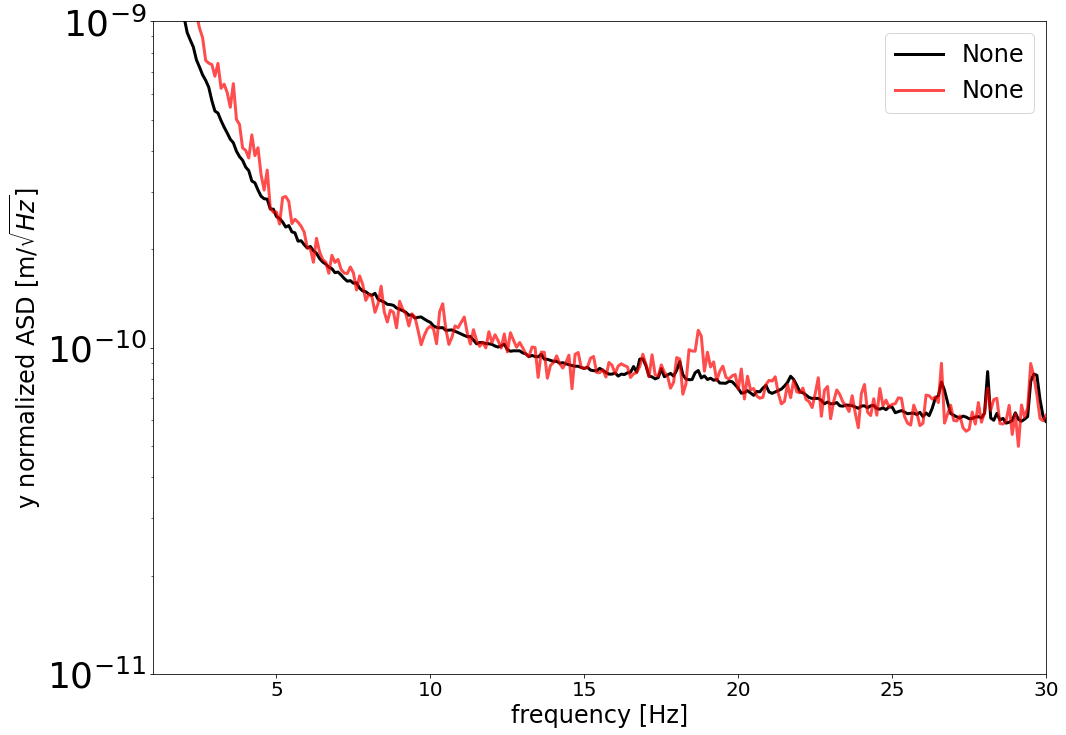

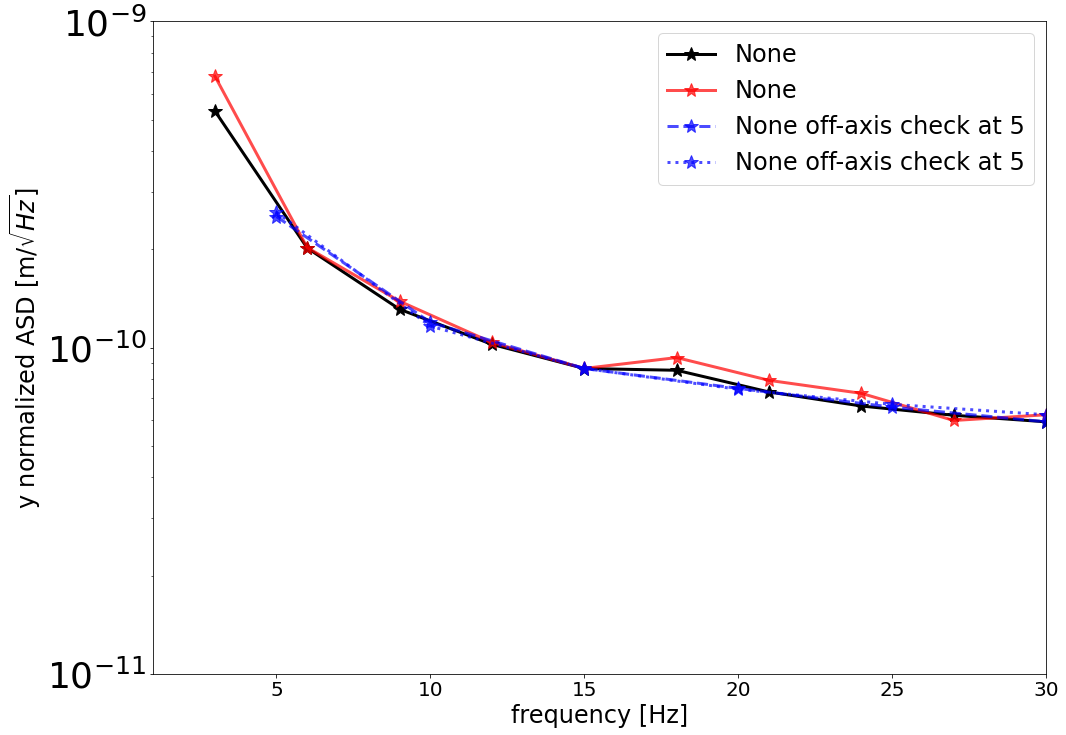

In [69]:
plot_compare_amplitudes_tot(3,df_Shaking3_1,df_NoShaking_1,method="ASD",lowxlim=1,upylim=1e-9,upxlim=30)

In [42]:
# folderName="/data/new_trap/20220615/Shaking/2/" 
# filePrefix="Shaking"
# freqs,df_Shaking11_1= extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True,calibrationFactorX=calibrationFactorX,calibrationFactorY=calibrationFactorY)
# df_Shaking11_1.to_pickle("Results/Shaking_2_20220615.npy")
df_Shaking11_1 = np.load("Results/Shaking_2_20220615.npy", allow_pickle=True)

In [43]:
folderName="/data/new_trap/20220617/Shaking/1/" 
filePrefix="Shaking"
freqs,df_Shaking11_2= extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True,calibrationFactorX=calibrationFactorX,calibrationFactorY=calibrationFactorY)
df_Shaking11_2.to_pickle("Results/Shaking_1_20220617.npy")


1000
The process took 56.98
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
index       1000 non-null int64
cantPosY    1000 non-null object
xAmp        1000 non-null object
xPhase      1000 non-null object
xPSD        1000 non-null object
yAmp        1000 non-null object
yPhase      1000 non-null object
yPSD        1000 non-null object
checkStd    1000 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.5 GB
None


In [44]:
folderName="/data/new_trap/20220620/Shaking/1/" 
filePrefix="Shaking"
freqs,df_Shaking11_2= extract_data_to_df(folderName,filePrefix,maxFiles=1000,filterStd=True,calibrationFactorX=calibrationFactorX,calibrationFactorY=calibrationFactorY)
df_Shaking11_3.to_pickle("Results/Shaking_1_20220620.npy")


875
The process took 49.68
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 9 columns):
index       872 non-null int64
cantPosY    872 non-null object
xAmp        872 non-null object
xPhase      872 non-null object
xPSD        872 non-null object
yAmp        872 non-null object
yPhase      872 non-null object
yPSD        872 non-null object
checkStd    872 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.3 GB
None


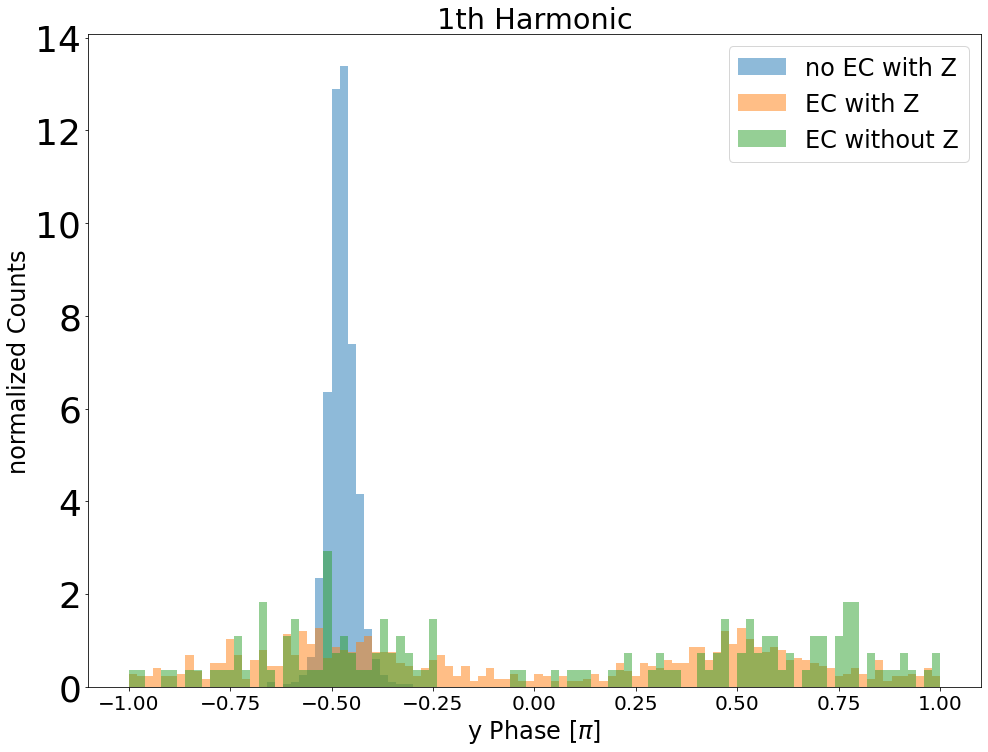

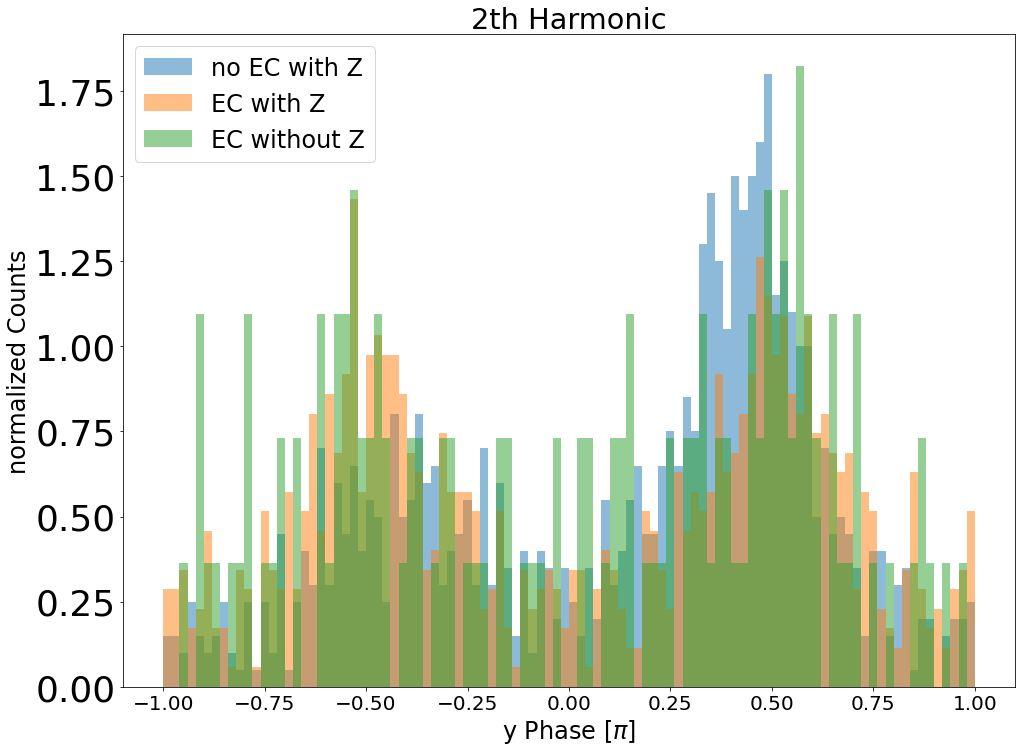

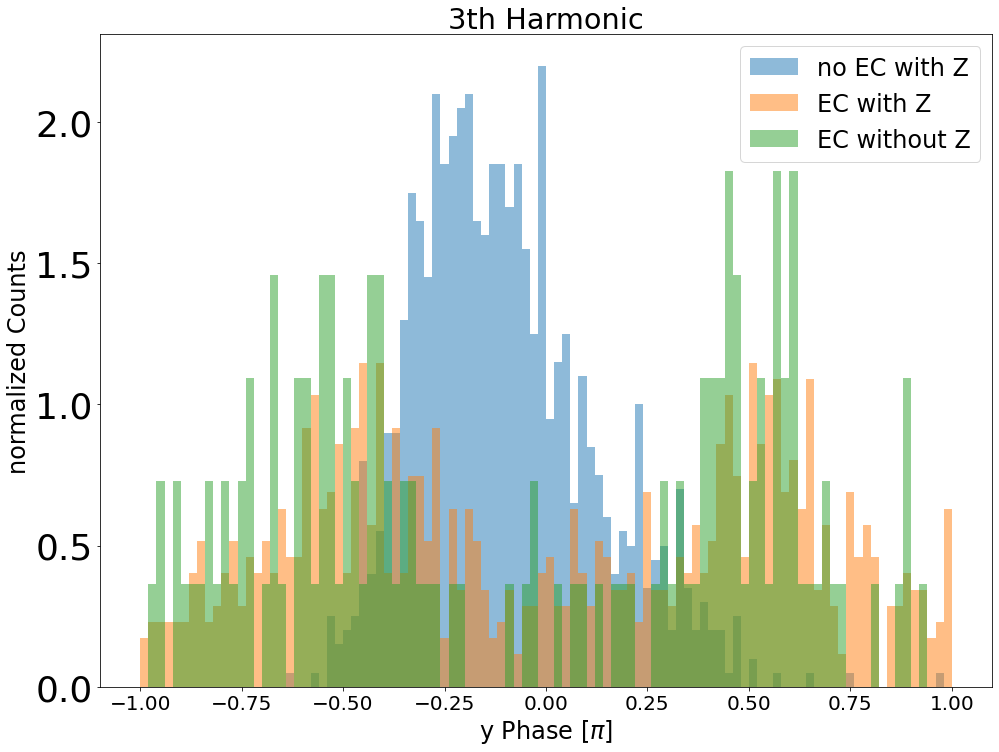

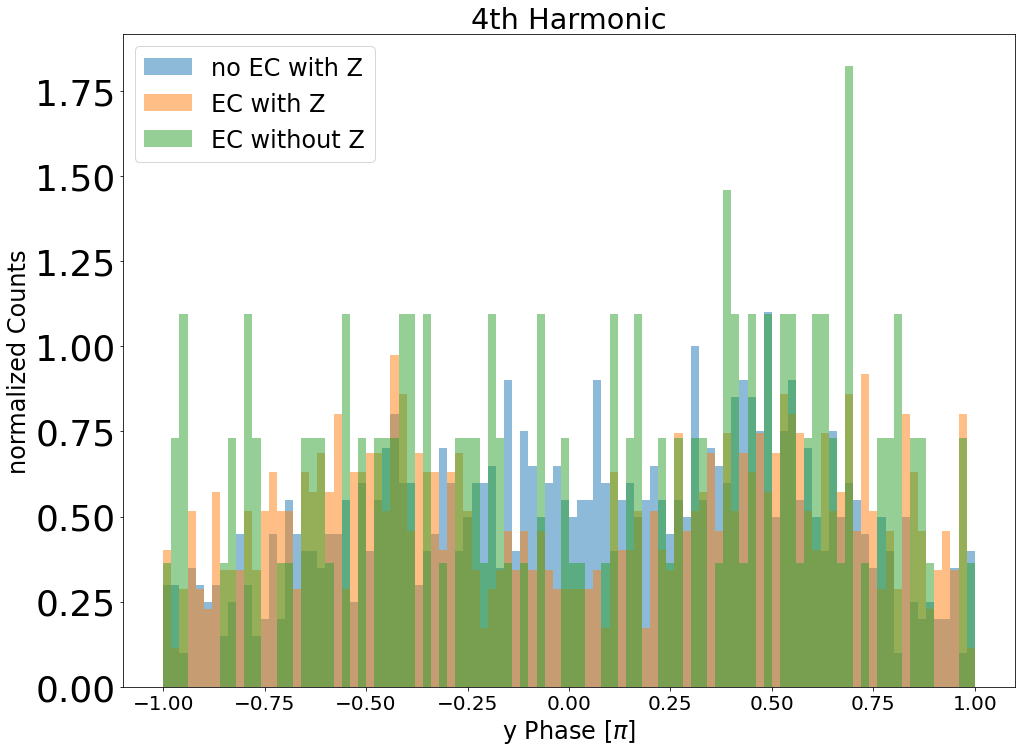

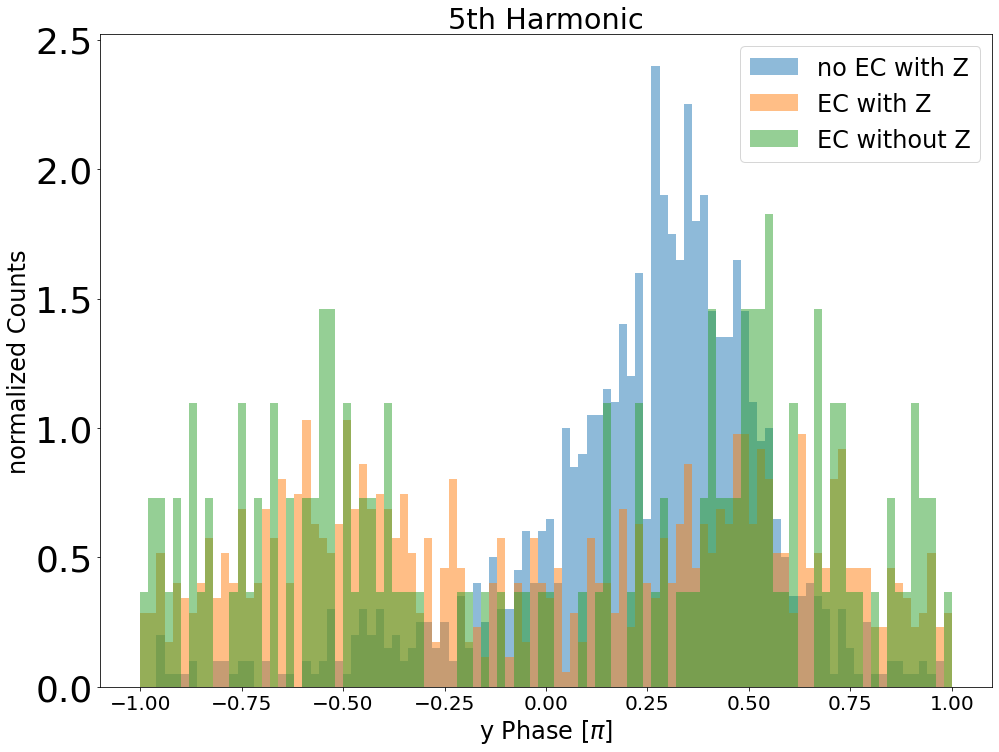

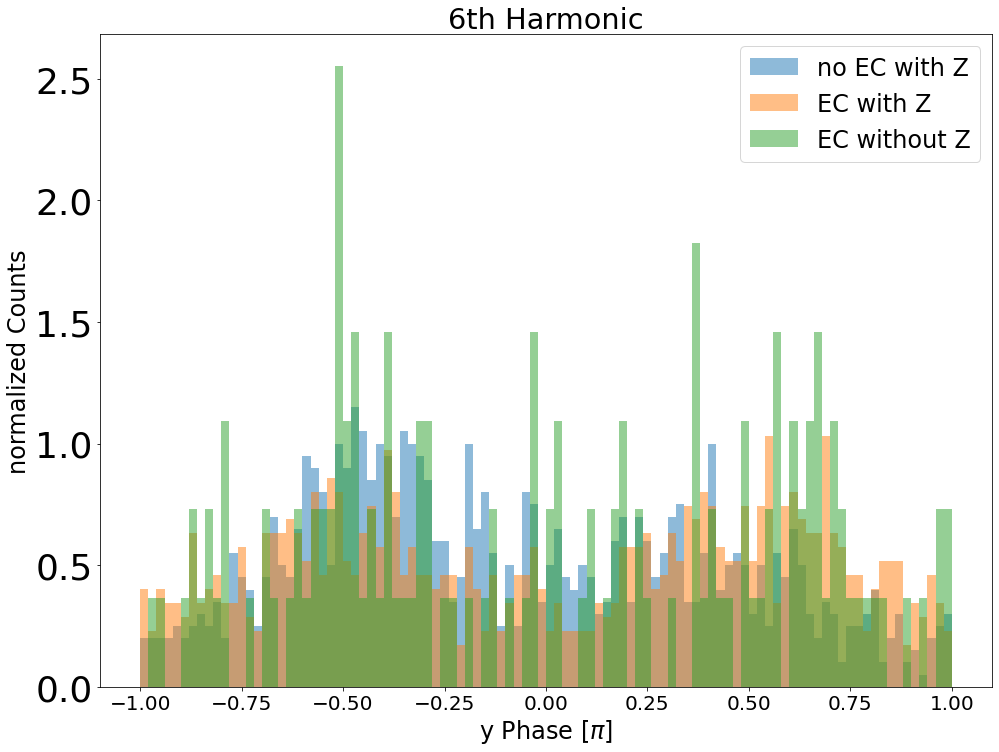

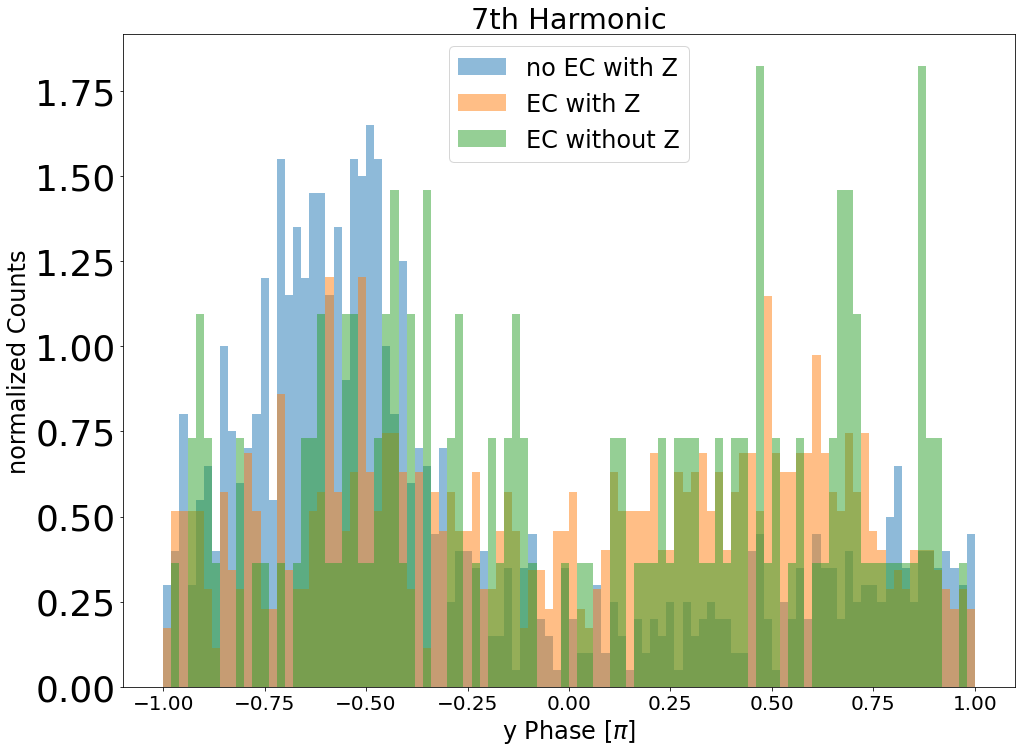

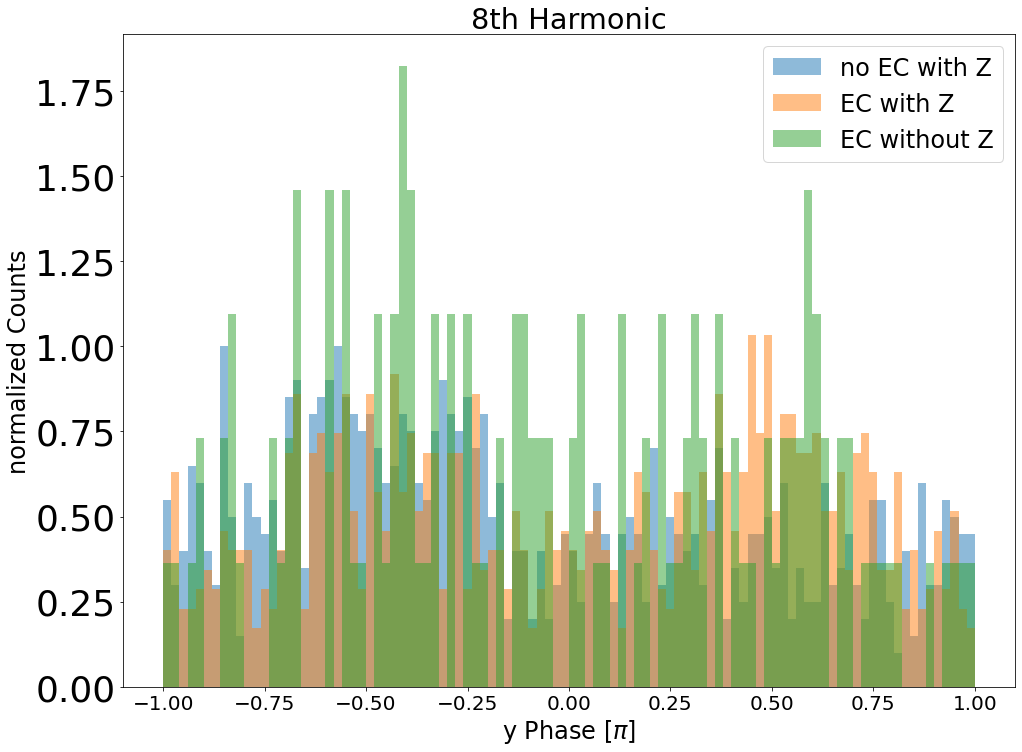

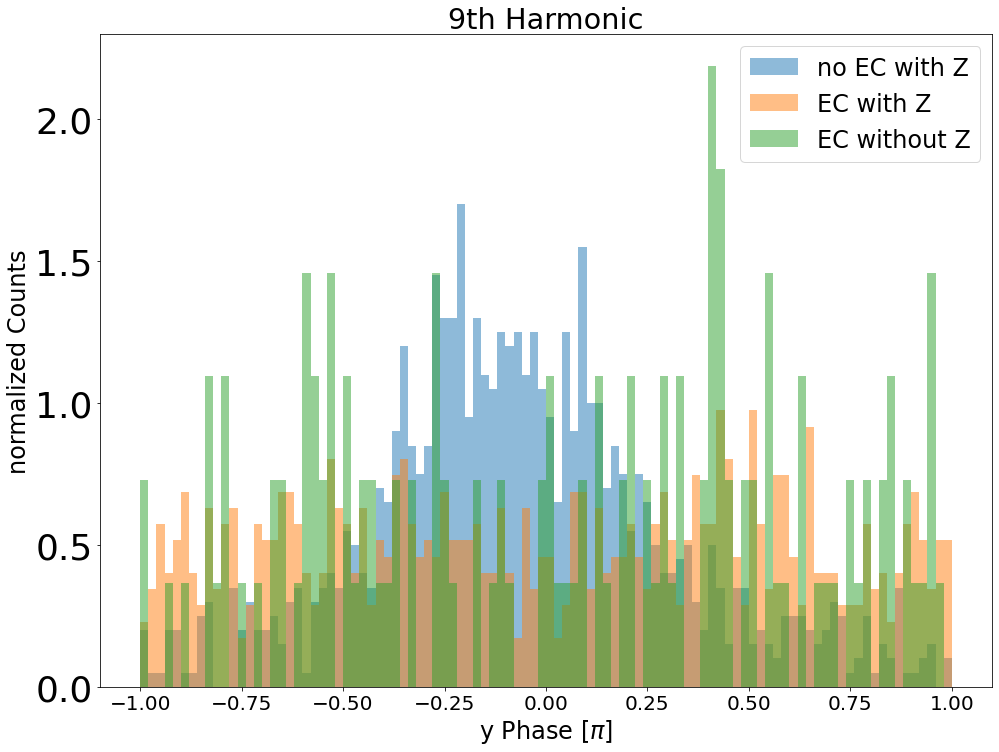

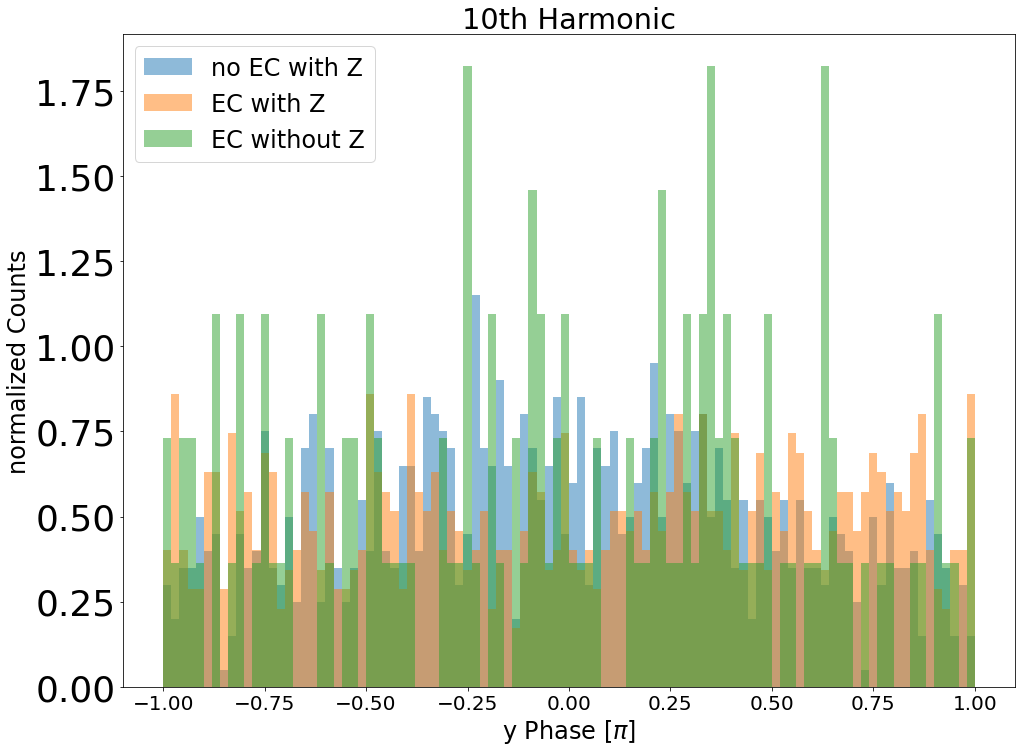

In [49]:
plot_compare_phases_all(11,dfs=[df_Shaking11_1,df_Shaking11_2,df_Shaking11_3],labels=["no EC with Z","EC with Z","EC without Z"])

In [50]:
folderName="/data/new_trap/20220621/Shaking/1/" 
filePrefix="Shaking"
freqs,df_Shaking11_4= extract_data_to_df(folderName,filePrefix,maxFiles=150,filterStd=True,calibrationFactorX=calibrationFactorX,calibrationFactorY=calibrationFactorY)


138
The process took 8.91
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 9 columns):
index       138 non-null int64
cantPosY    138 non-null object
xAmp        138 non-null object
xPhase      138 non-null object
xPSD        138 non-null object
yAmp        138 non-null object
yPhase      138 non-null object
yPSD        138 non-null object
checkStd    138 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 210.7 MB
None


In [51]:
folderName="/data/new_trap/20220621/Shaking/2/" 
filePrefix="Shaking"
freqs,df_Shaking11_5= extract_data_to_df(folderName,filePrefix,maxFiles=150,filterStd=True,calibrationFactorX=calibrationFactorX,calibrationFactorY=calibrationFactorY)


138
The process took 7.79
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 9 columns):
index       137 non-null int64
cantPosY    137 non-null object
xAmp        137 non-null object
xPhase      137 non-null object
xPSD        137 non-null object
yAmp        137 non-null object
yPhase      137 non-null object
yPSD        137 non-null object
checkStd    137 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 209.1 MB
None


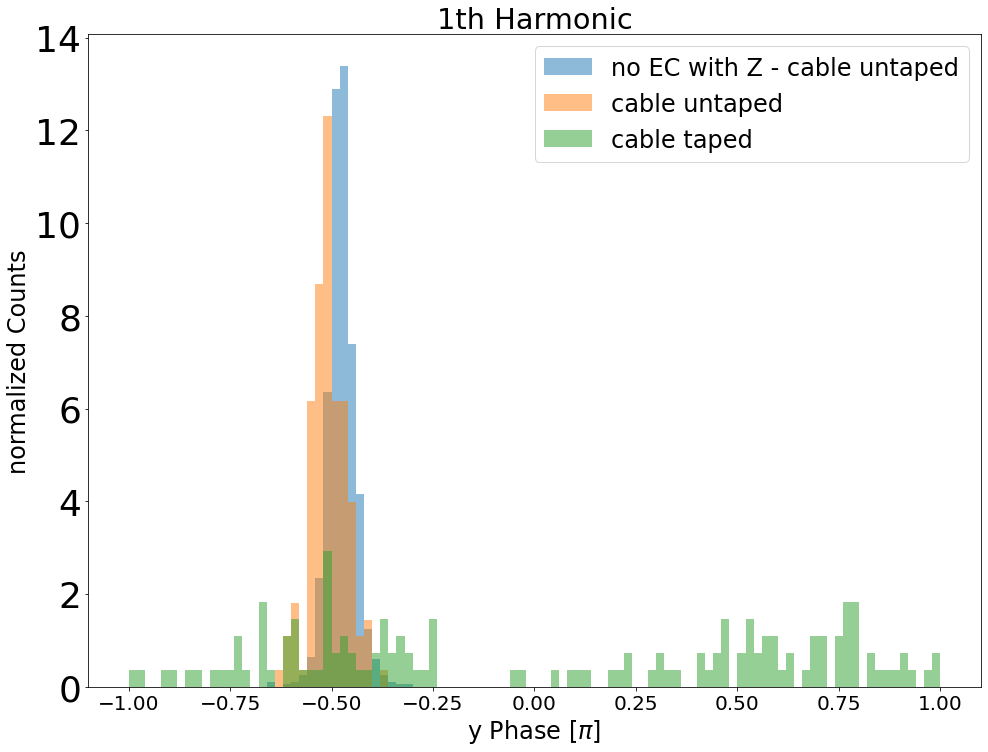

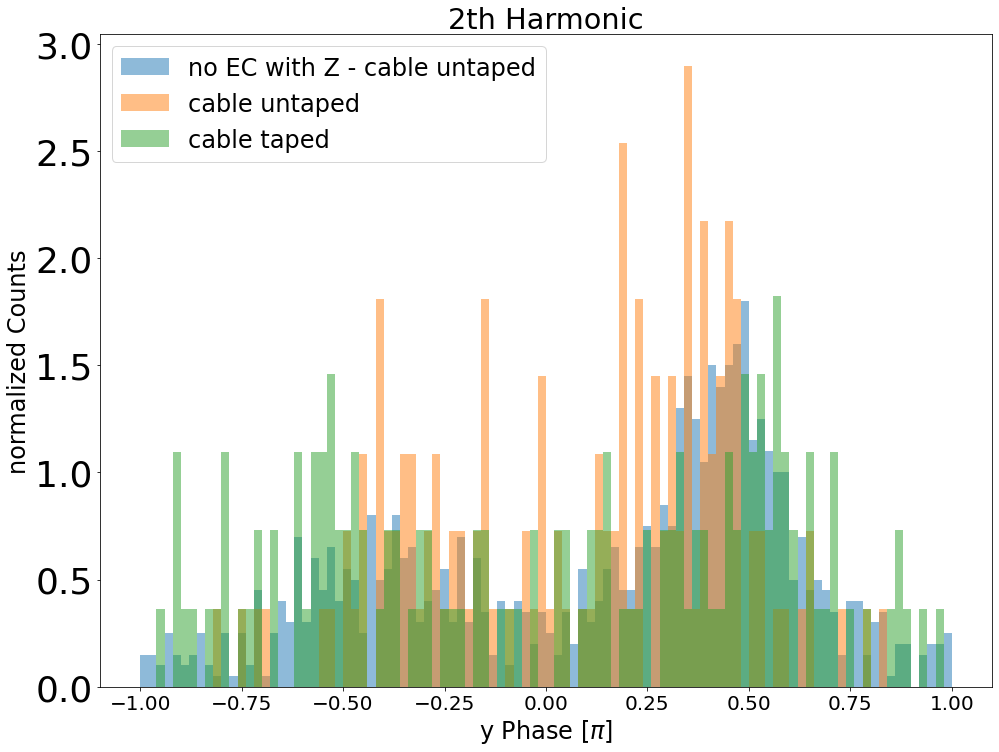

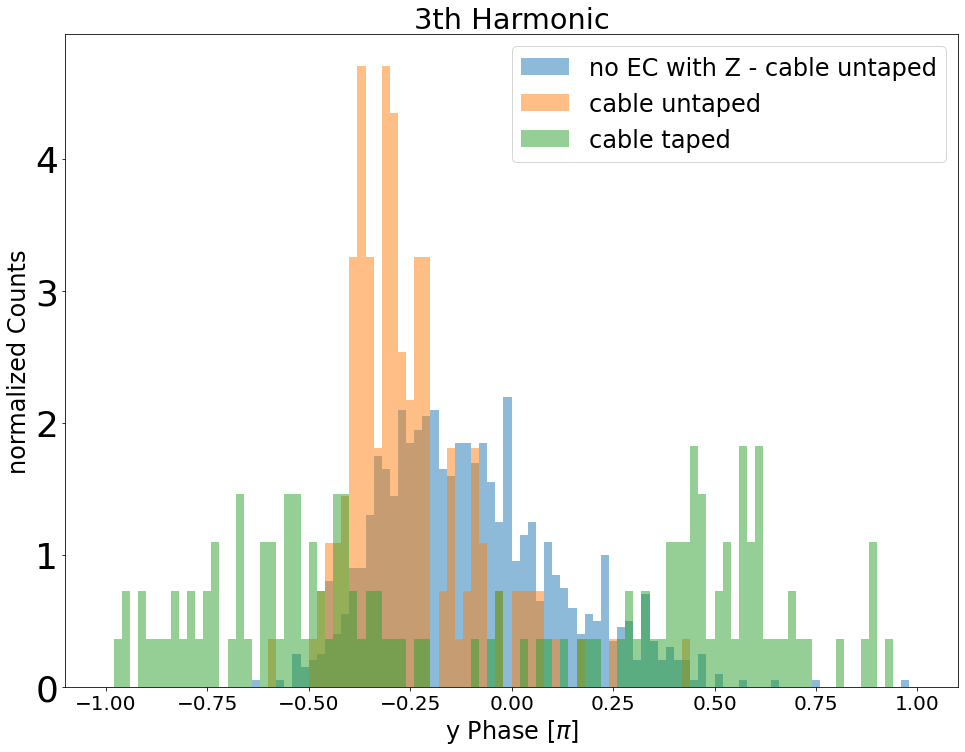

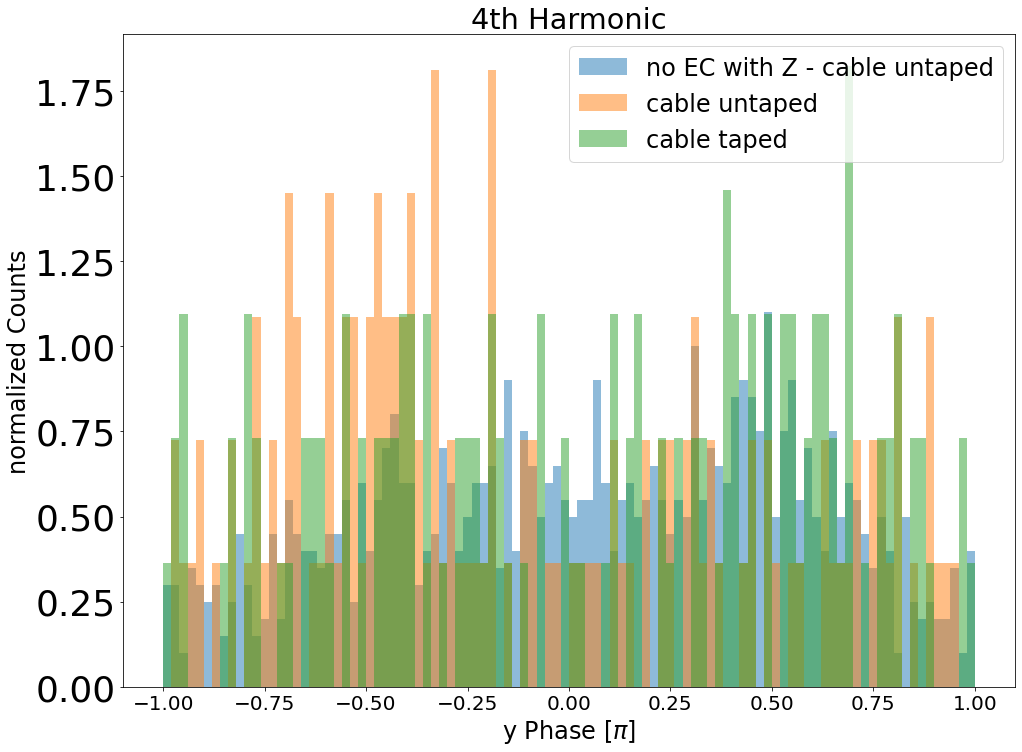

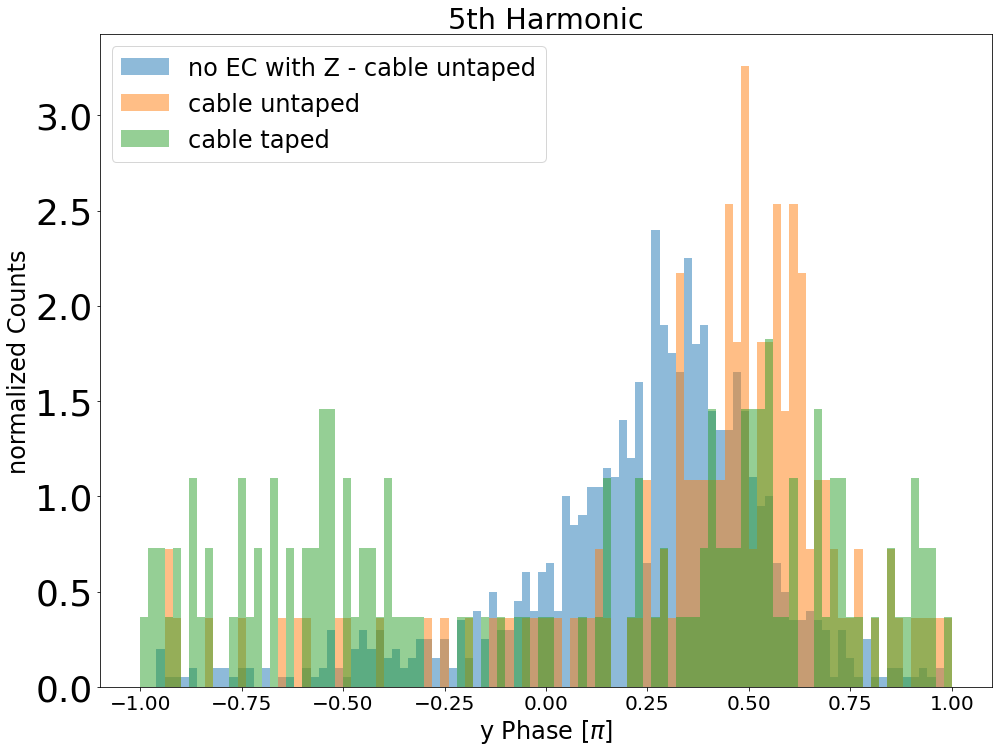

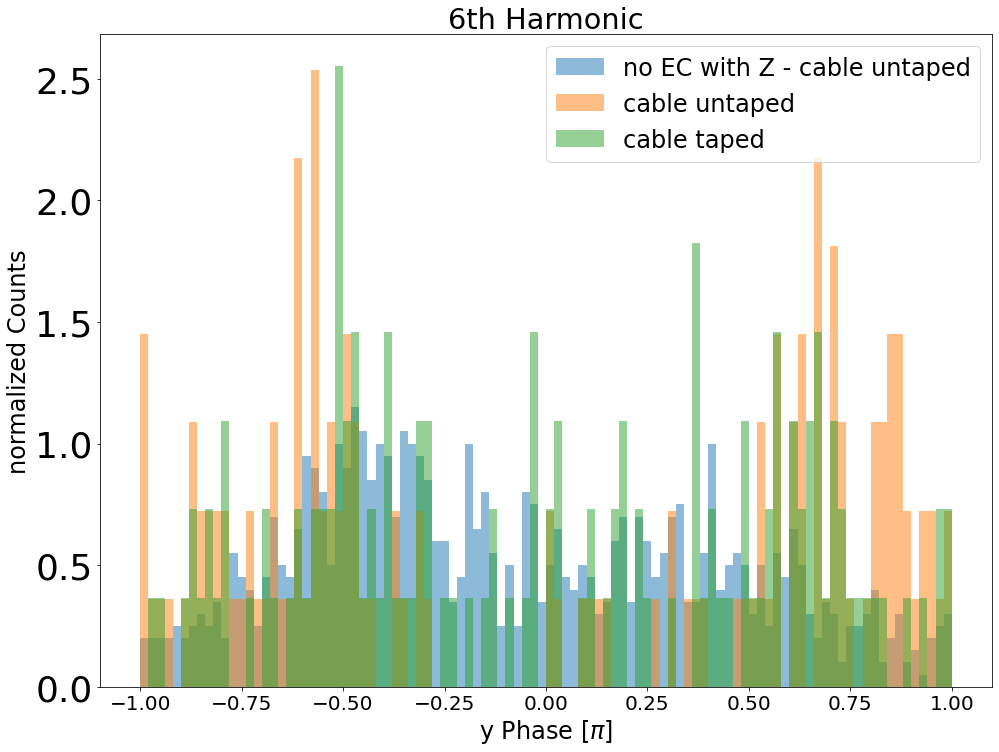

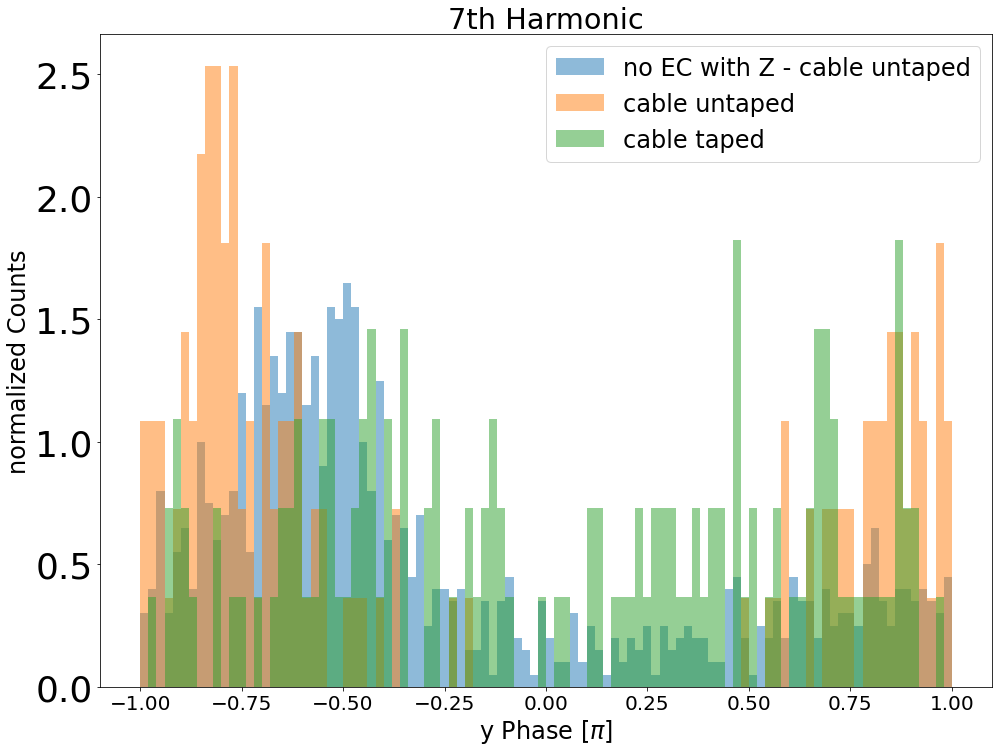

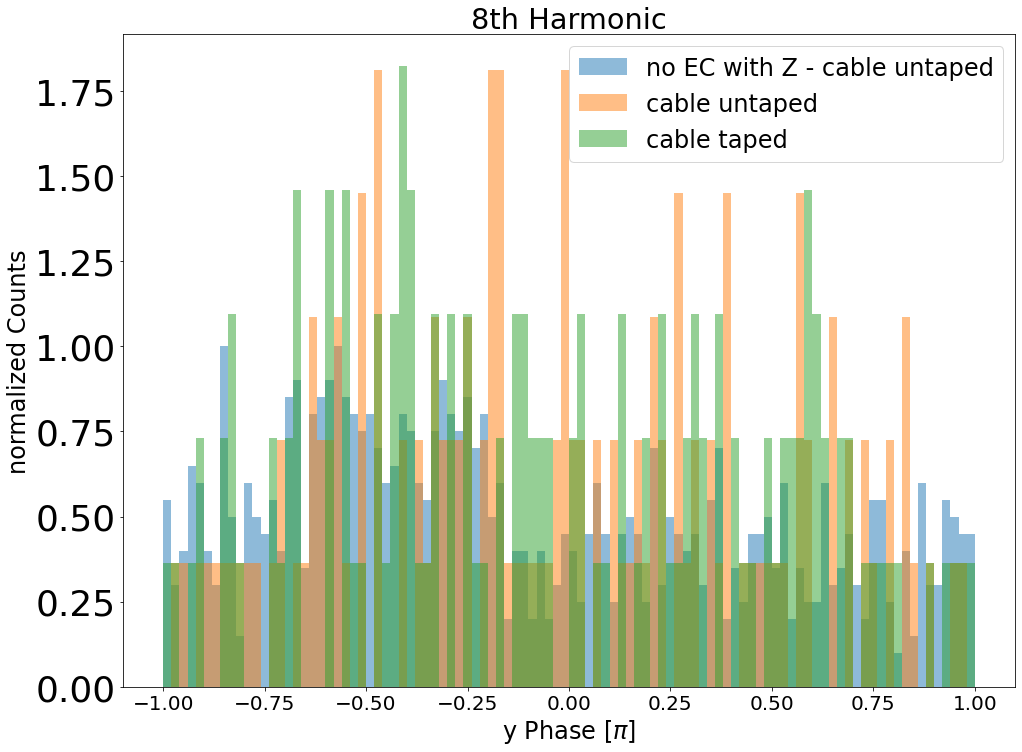

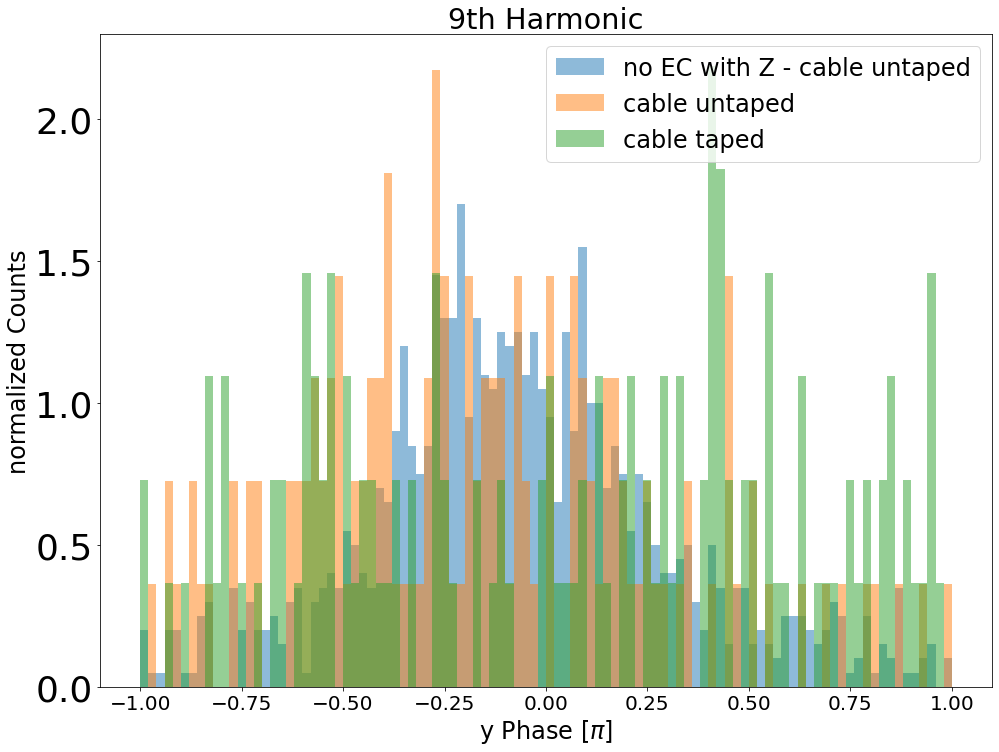

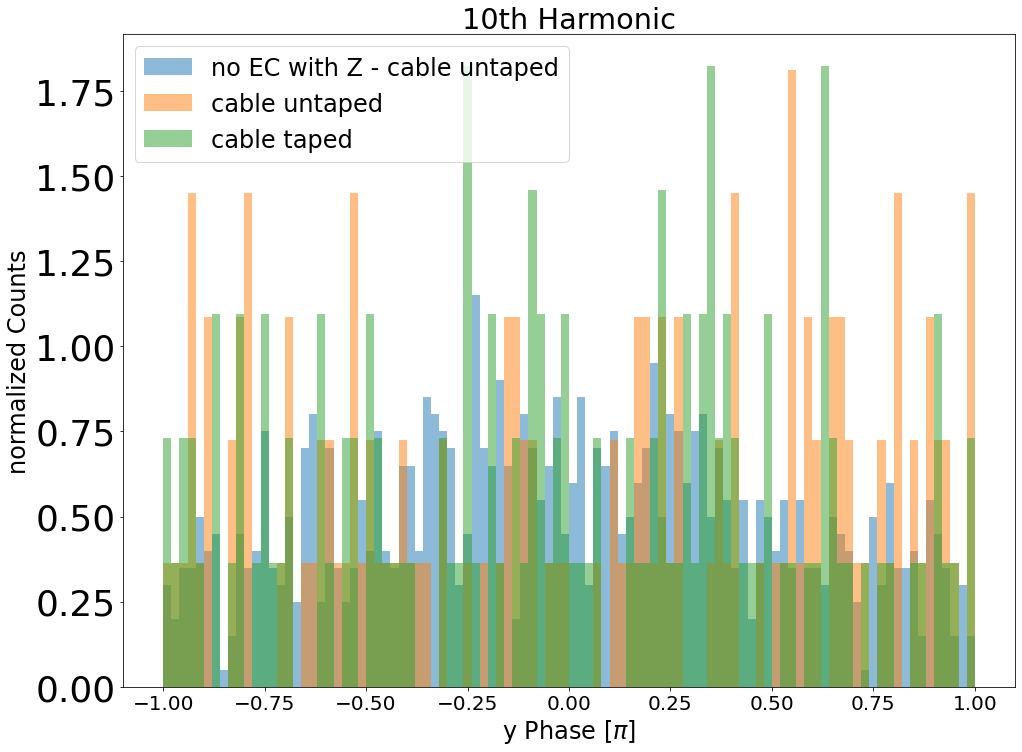

In [52]:
plot_compare_phases_all(11,dfs=[df_Shaking11_1,df_Shaking11_4,df_Shaking11_5],labels=["no EC with Z - cable untaped","cable untaped ","cable taped"])

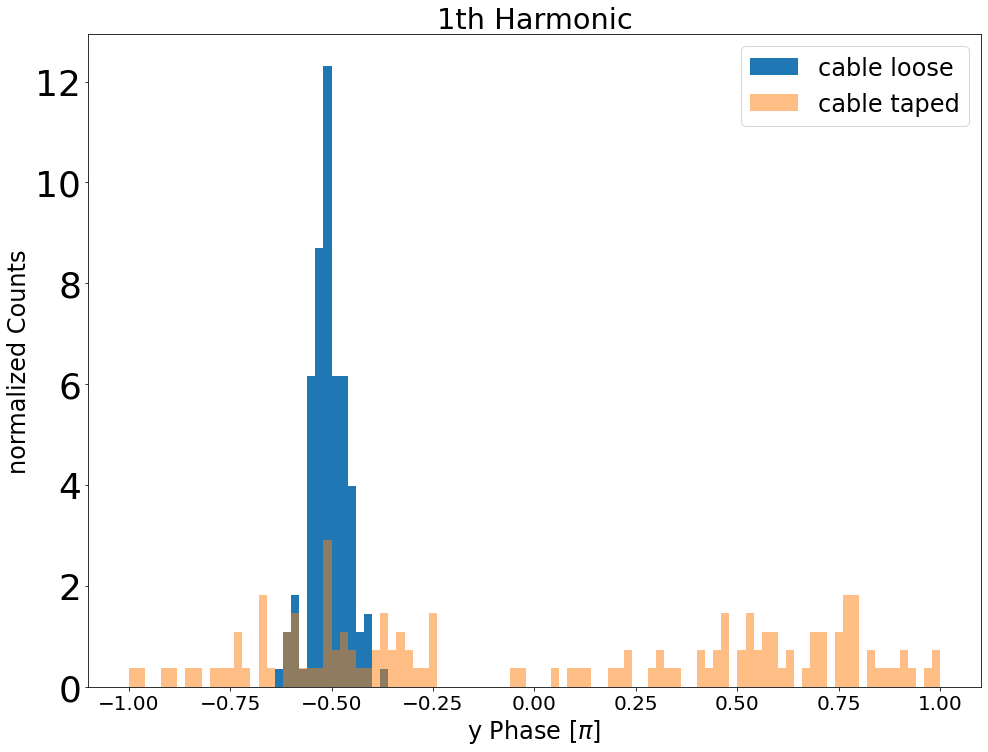

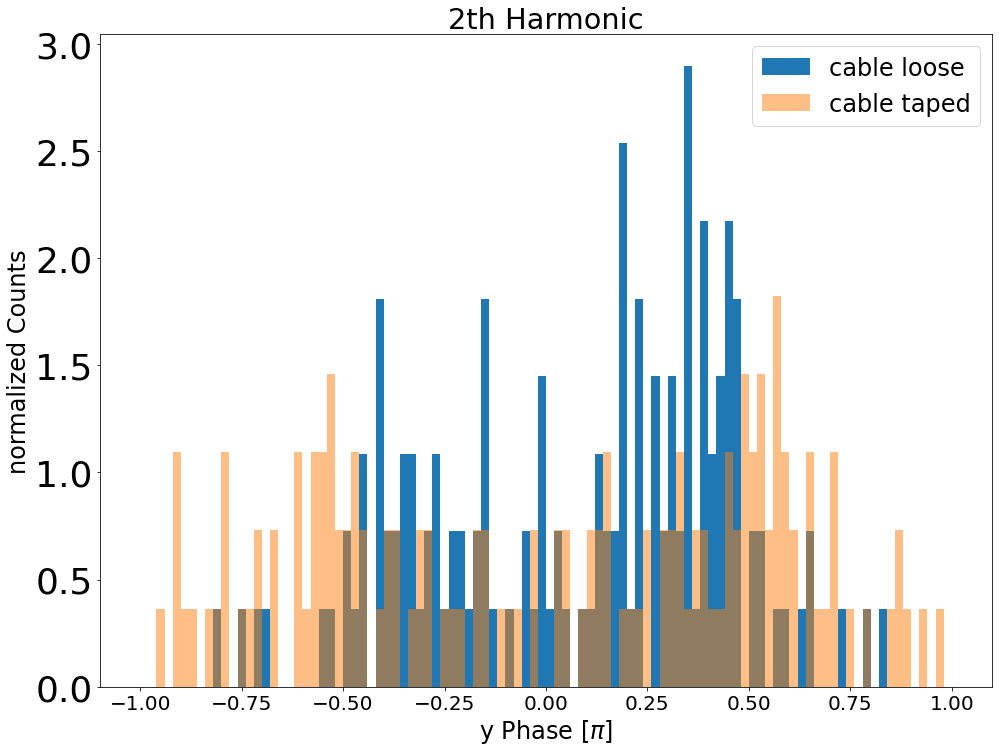

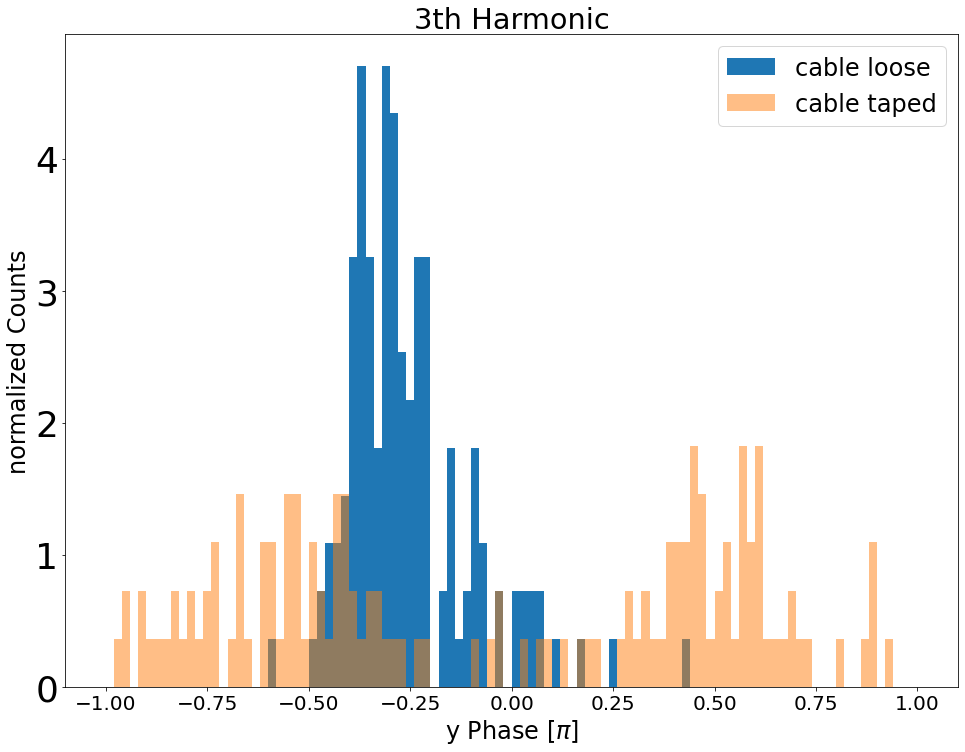

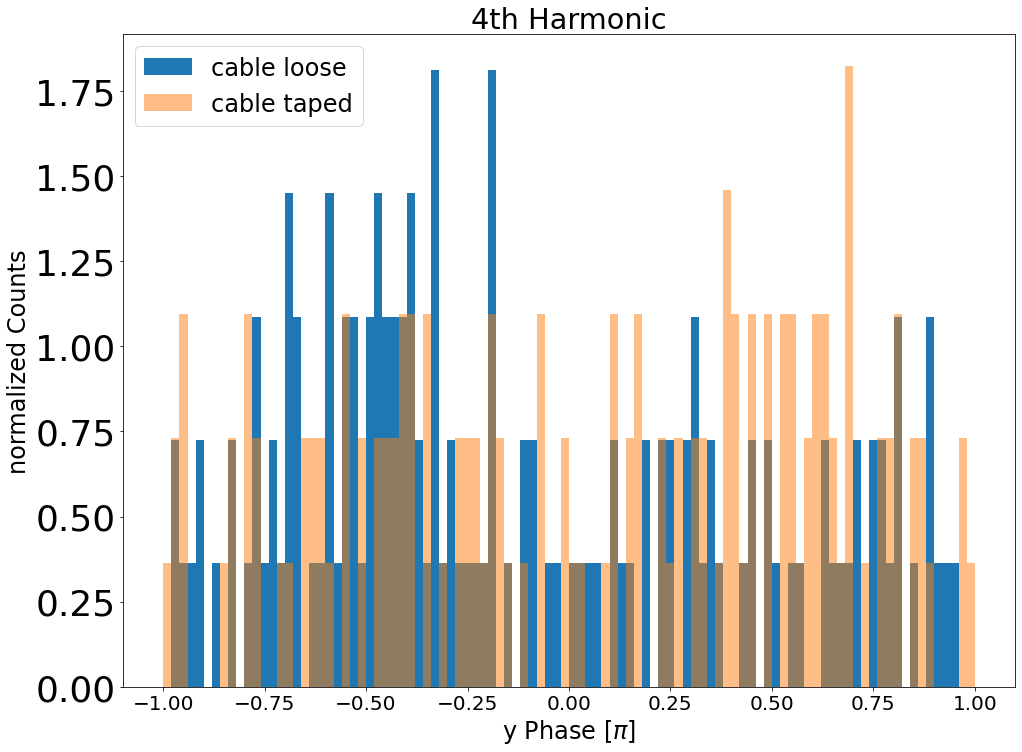

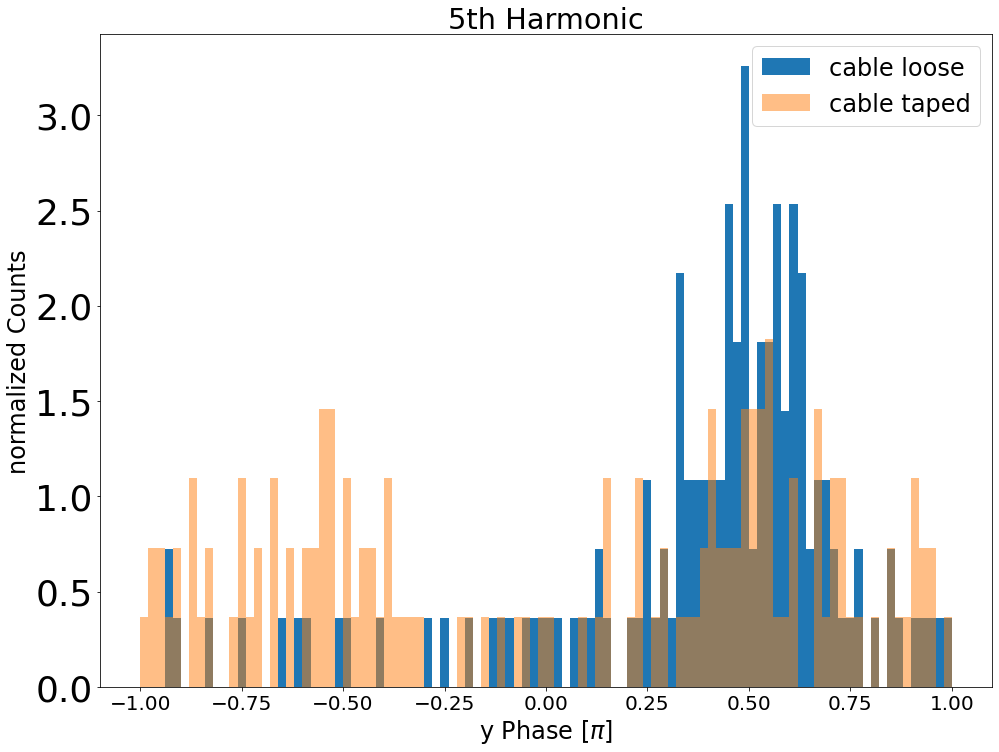

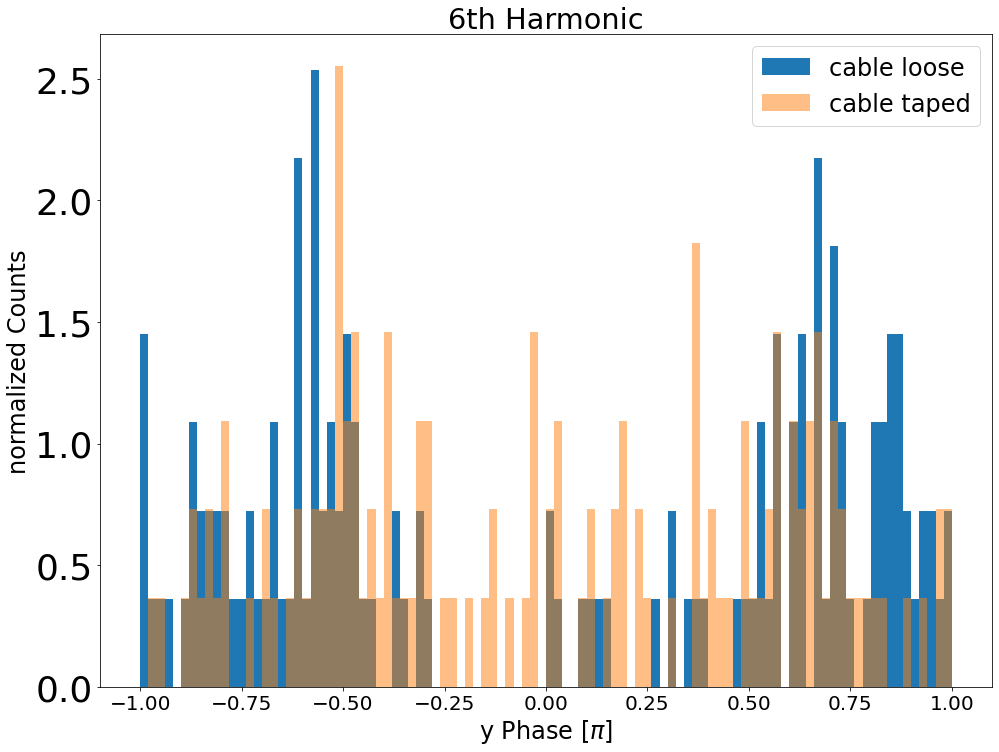

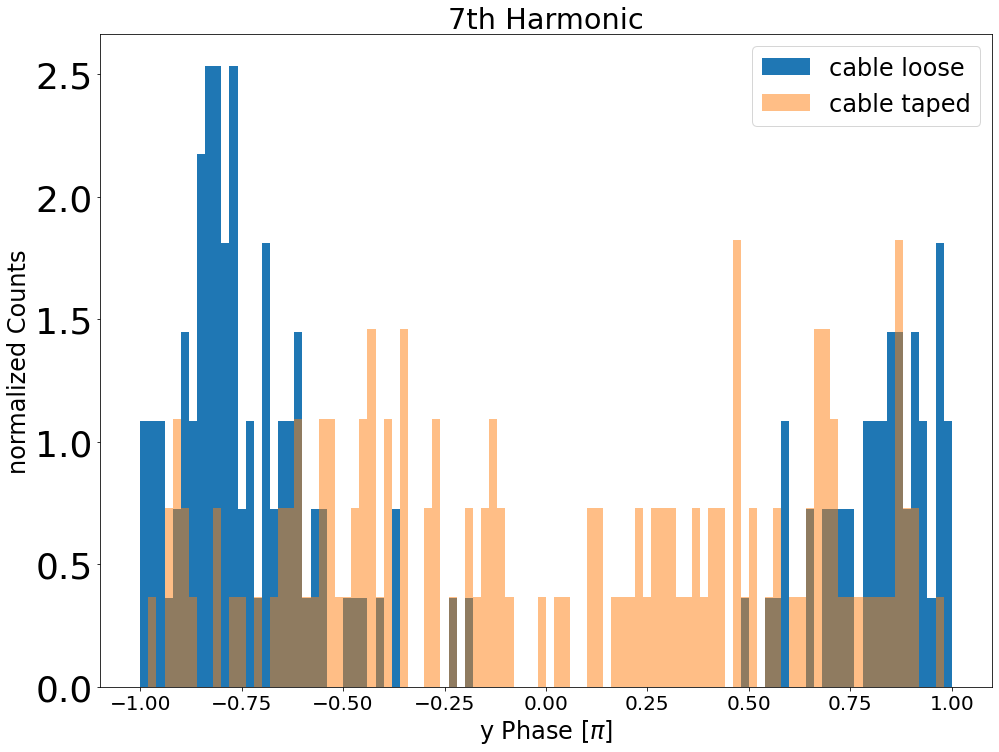

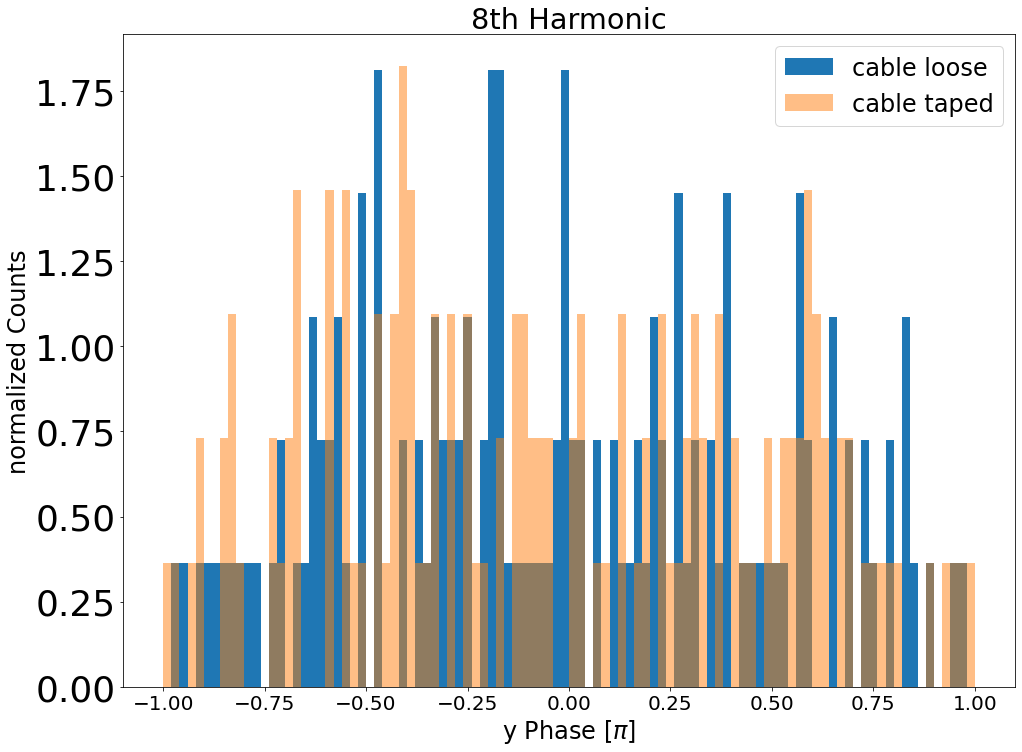

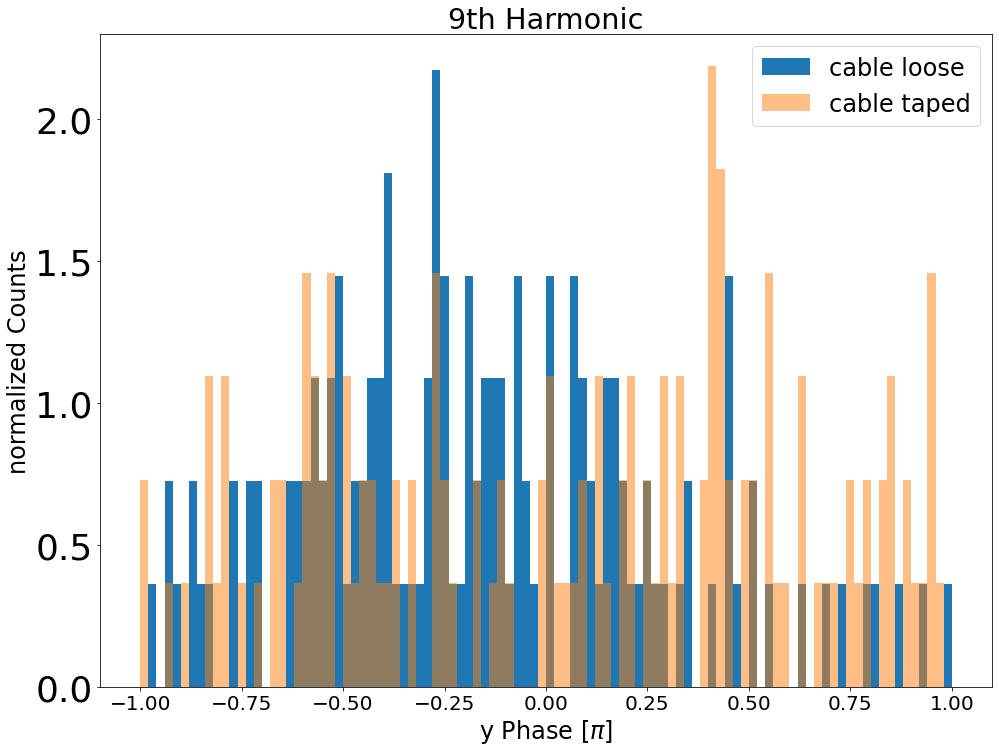

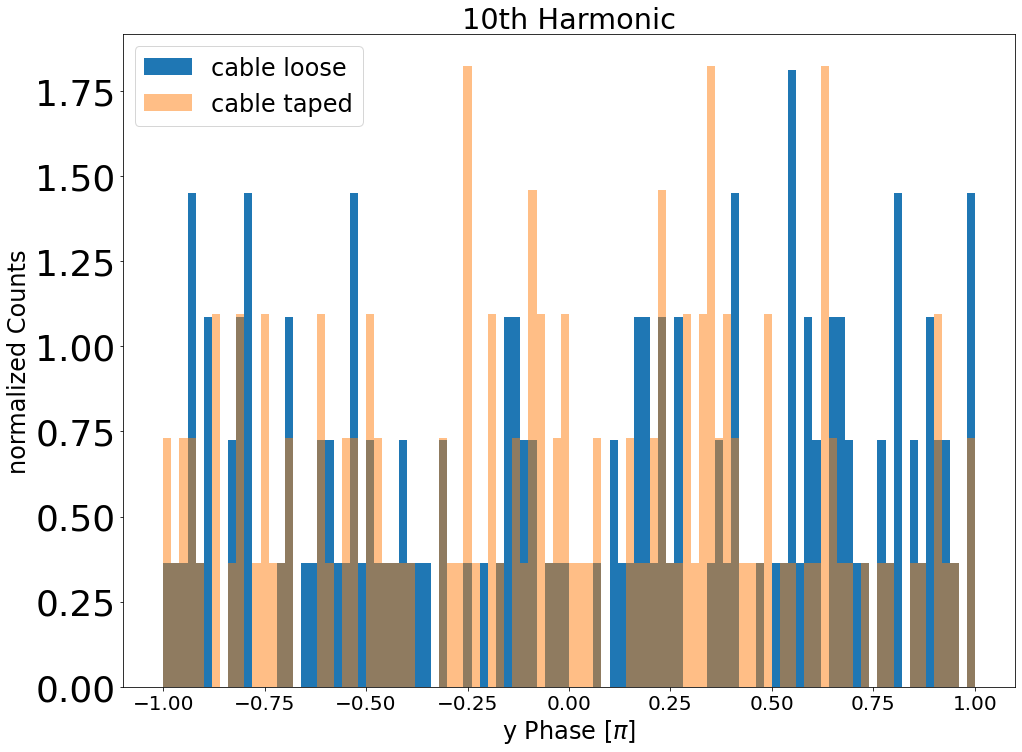

In [54]:
plot_compare_phases(11,df_Shaking11_4,df_Shaking11_5,axis="y",label1="cable loose",label2="cable taped")

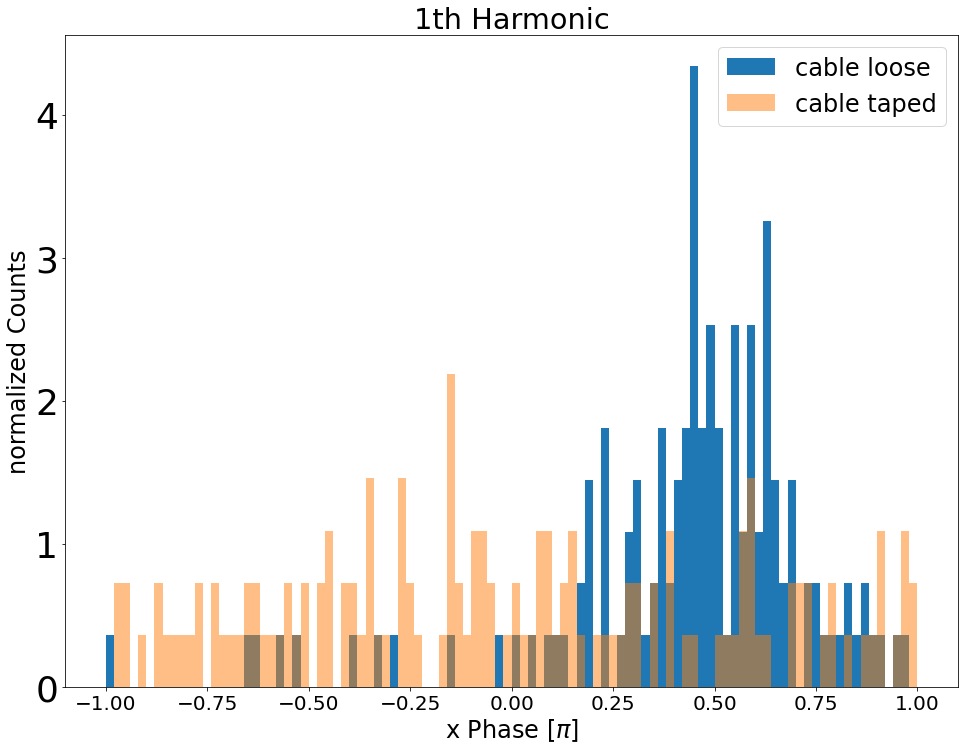

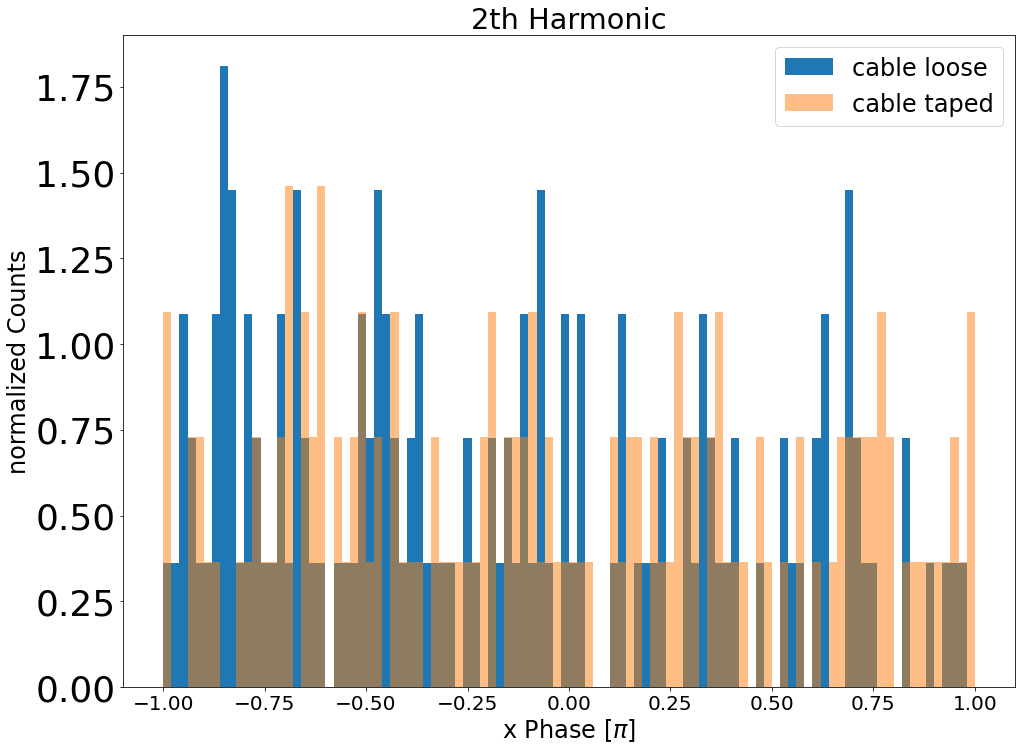

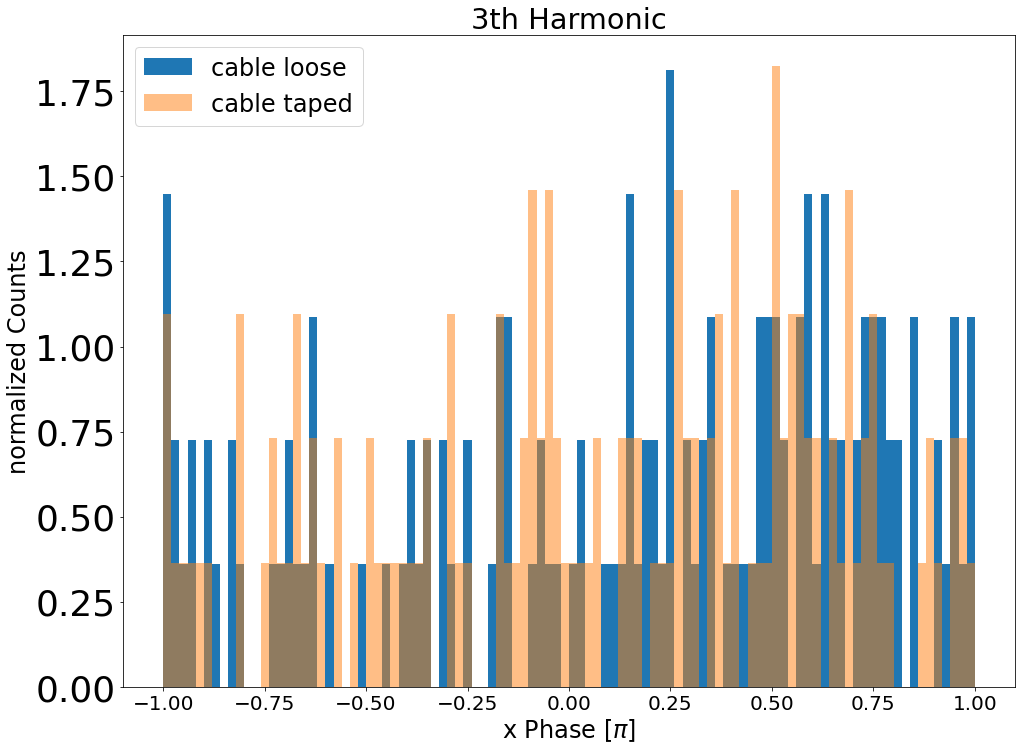

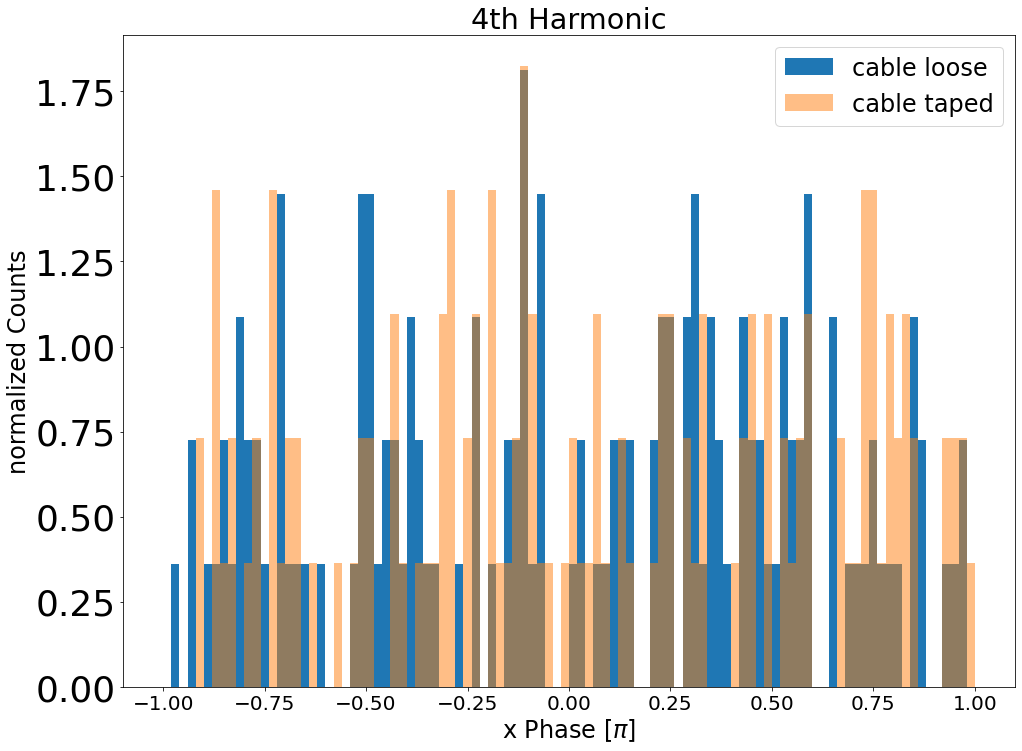

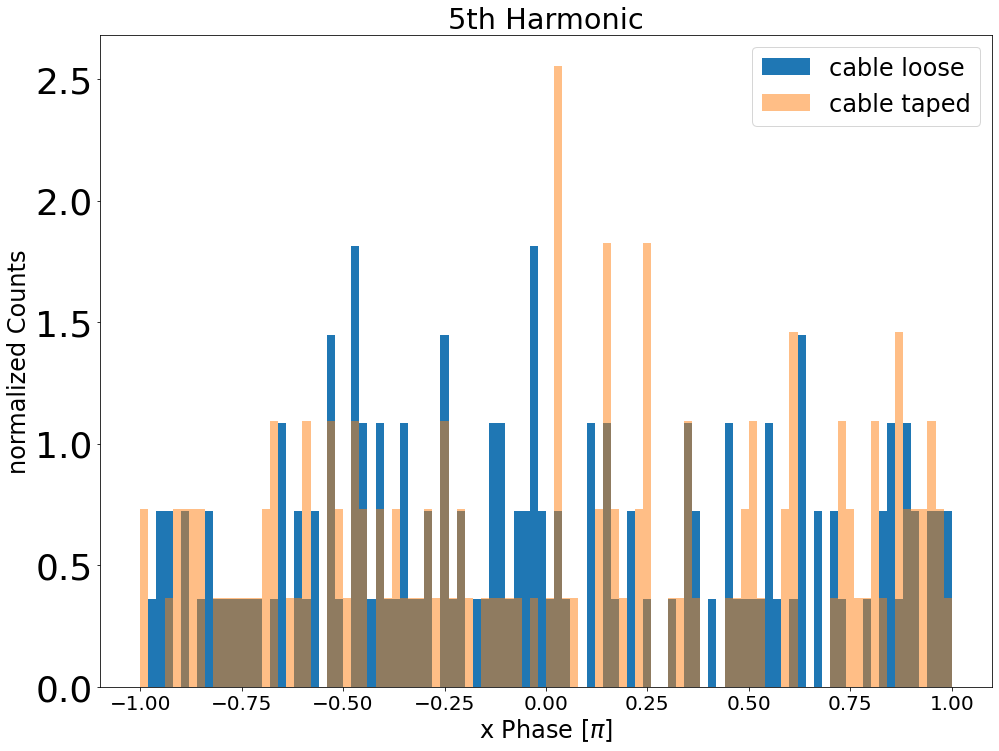

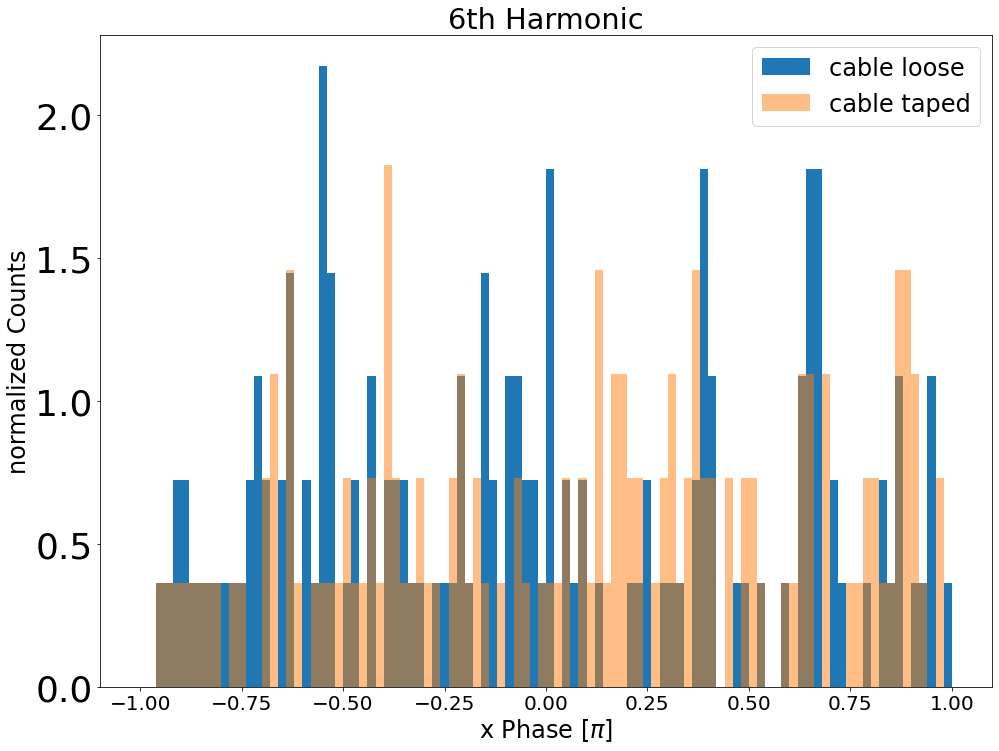

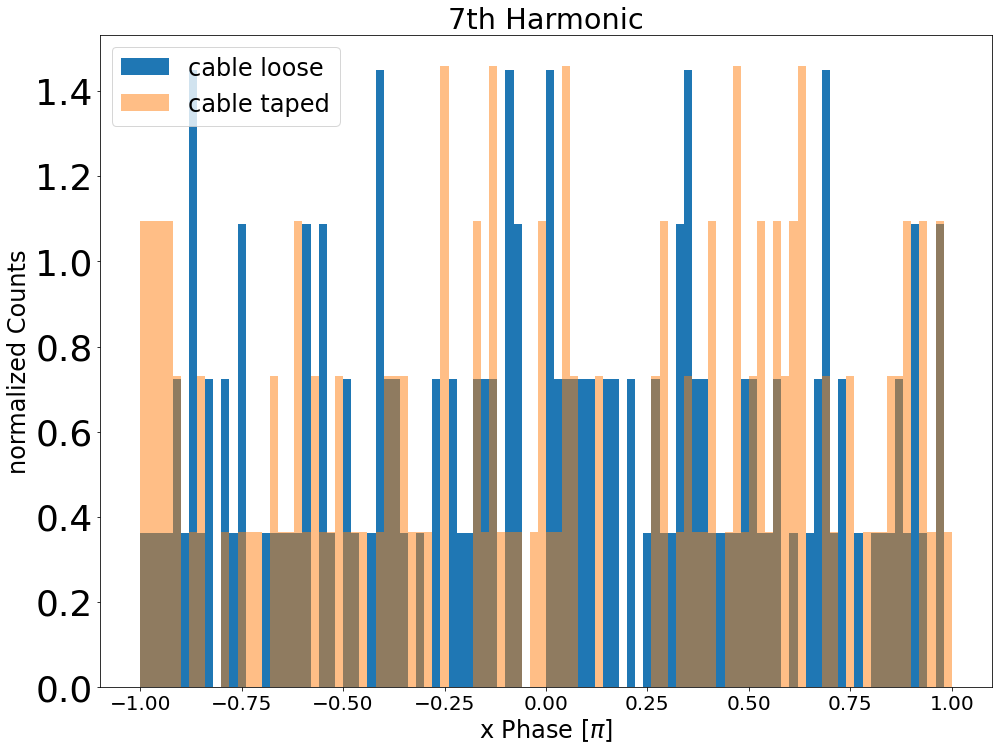

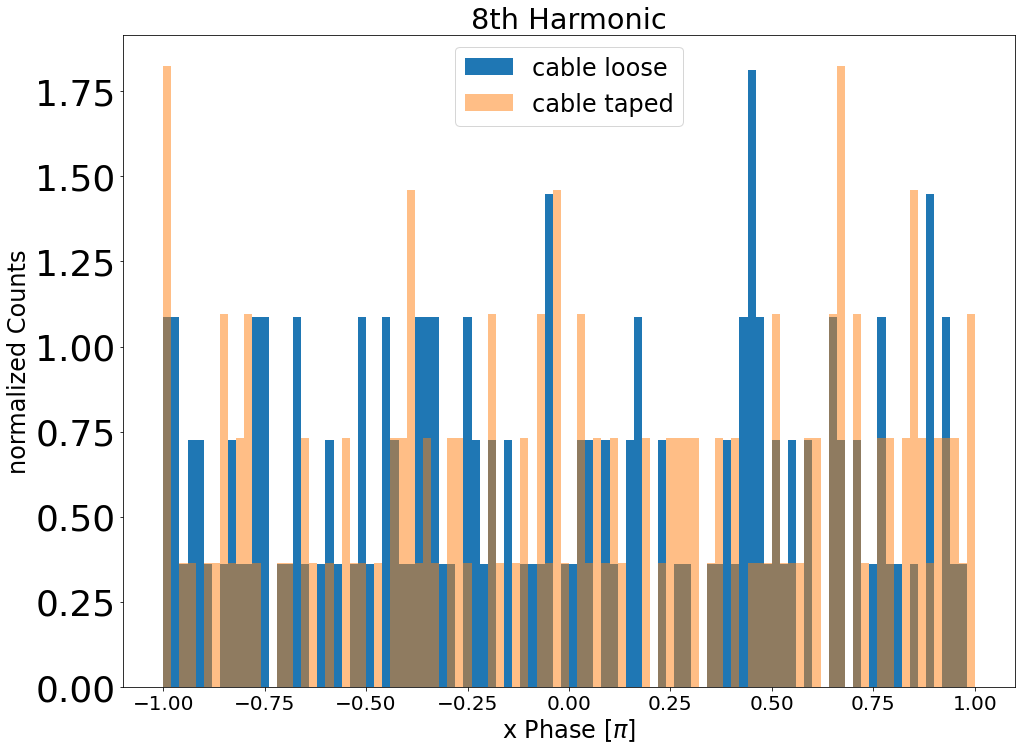

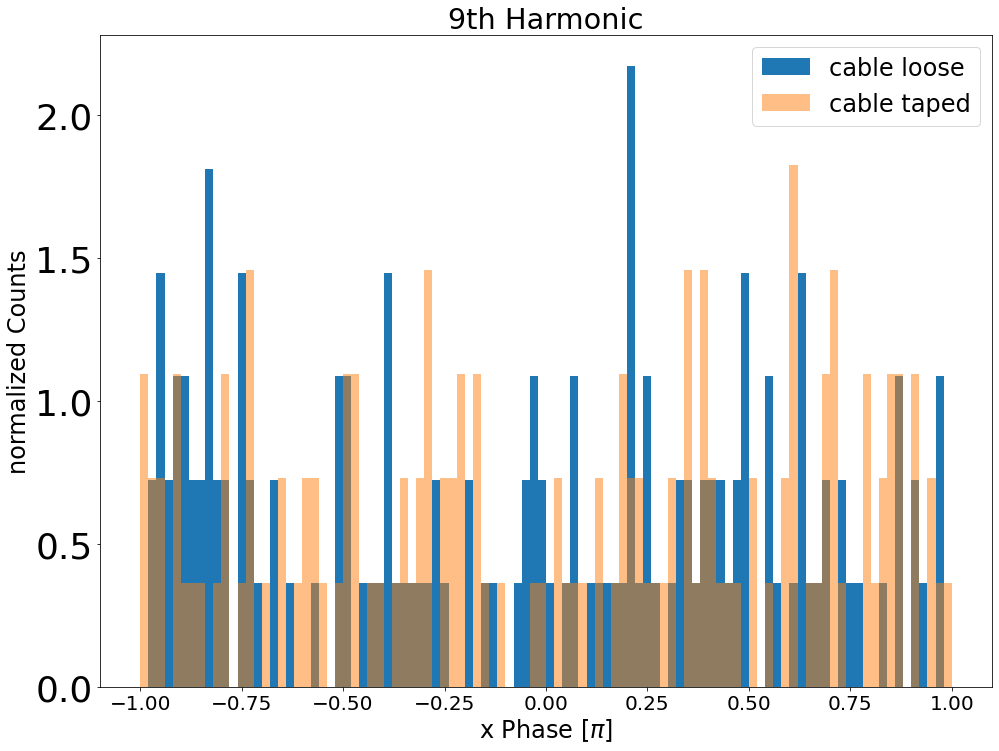

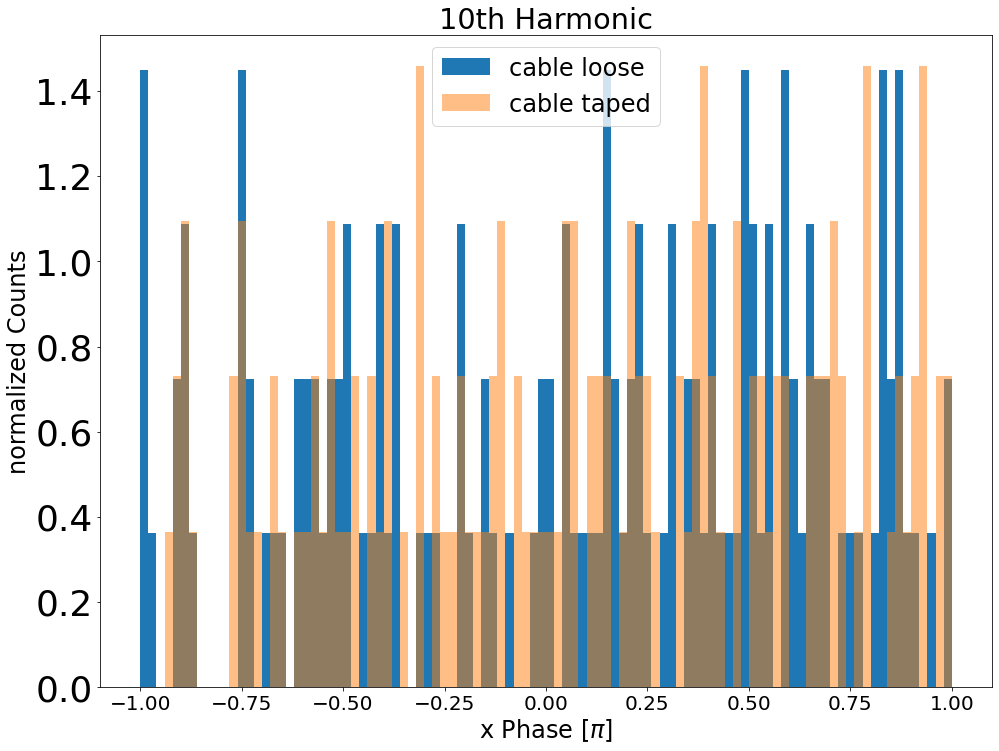

In [55]:
plot_compare_phases(11,df_Shaking11_4,df_Shaking11_5,axis="x",label1="cable loose",label2="cable taped")

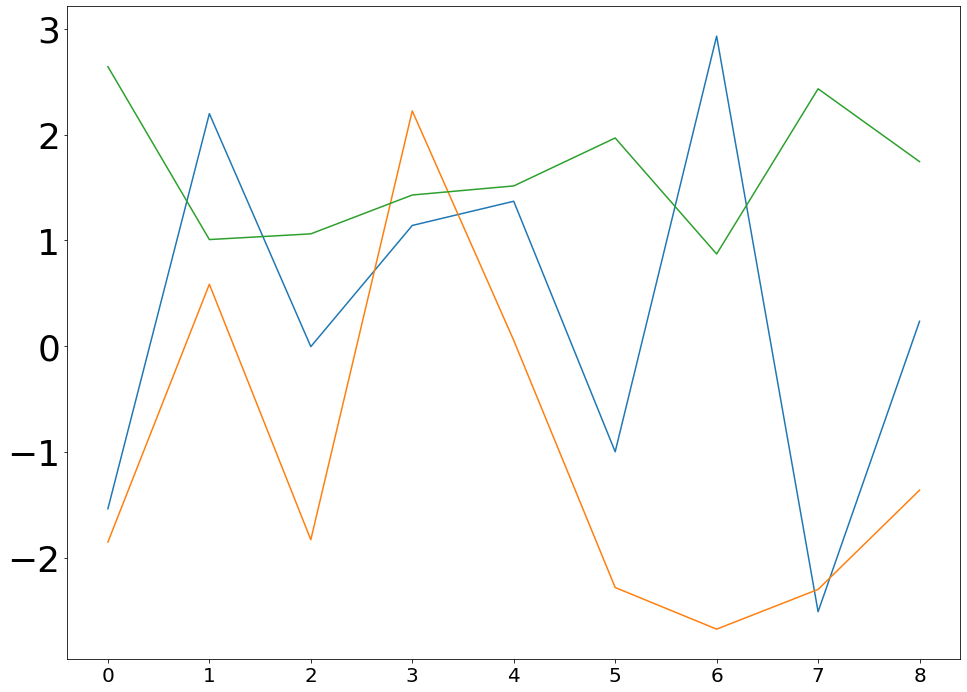

In [29]:
plt.plot(df_Shaking11_1["yPhase"][2][110:1100:110])
plt.plot(df_Shaking11_2["yPhase"][2][110:1100:110])
plt.plot(df_Shaking11_3["yPhase"][2][110:1100:110])


In [52]:
folderName="/data/new_trap/20220620/Shaking/1/" 
filePrefix="Shaking"
freqs,df_Shaking11_3= extract_data_to_df(folderName,filePrefix,maxFiles=5000,filterStd=True,calibrationFactorX=calibrationFactorX,calibrationFactorY=calibrationFactorY)
#df_Shaking11_3.to_pickle("Results/Shaking_1_20220617.npy")

831
The process took 14.24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828 entries, 0 to 827
Data columns (total 9 columns):
index       828 non-null int64
cantPosY    828 non-null object
xAmp        828 non-null object
xPhase      828 non-null object
xPSD        828 non-null object
yAmp        828 non-null object
yPhase      828 non-null object
yPSD        828 non-null object
checkStd    828 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.2 GB
None
